In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
# 输出列时中间去掉省略号
pd.set_option('display.max_columns', None)

In [3]:
import numpy as np
from collections import defaultdict
from sklearn.metrics import roc_auc_score

# 标签list、预测list、用户id(did)
def gauc(labels, predict, uids):
    assert len(uids) == len(labels)
    assert len(uids) == len(predict)
    # defaultdict的作用是当调用group_score[uid]的时候如果不存在则创建一个空集合[],不会报错
    # 将属于某个用户的预测值放到一个list中
    group_score = defaultdict(lambda: [])
    # 将属于某个用户的实际值标签放到一个list中
    group_truth = defaultdict(lambda: [])
    for index, val in enumerate(labels):
        uid = uids[index]
        group_score[uid].append(predict[index])
        group_truth[uid].append(val)
    # 计算gauc值
    total_auc = 0
    impression_total = 0
    for user_id in group_truth:
        if label_with_xor(group_truth[user_id]):
            # np.asarray为将list列表转换为numpy数组
            auc = roc_auc_score(np.asarray(group_truth[user_id]), np.asarray(group_score[user_id]))
            # 单用户auc*单用户曝光数
            total_auc += auc * len(group_truth[user_id])
            # 总曝光数
            impression_total += len(group_truth[user_id])
    group_auc = (float(total_auc) / impression_total) if impression_total else 0
    group_auc = round(group_auc, 6)
    return group_auc
        
# 异或操作,有不一样的则为True
def label_with_xor(lists):
    if not lists:
        return False
    first = lists[0]
    for i in range(1, len(lists)):
        if lists[i] != first:
            return True
    return False

In [4]:
import gc
# 节省内存
# df为datafram,array为要转换为category的数组
def reduce_mem(df, array):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        # dtypes返回数据元素的数据类型,如aaa = np.array([1,2,3]), aaa.dtype: int64
        # type返回数据结构类型,如a = 10,type(a): int; aa = [1,2,3], type(aa):list
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.uint64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                    df[col] = pd.to_numeric(df[col], downcast='float')
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                    df[col] = pd.to_numeric(df[col], downcast='float')
                else:
                    df[col] = df[col].astype(np.float64)
                    df[col] = pd.to_numeric(df[col], downcast='float')             
    for cat_f in array:
        # category类型在底层使用整型数值来表示该列的值，而不是用原值。Pandas用一个字典来构建这些整型数据到原数据的映射关系。
        # 当一列只包含有限种值时(mod、mf、aver、sver这几个字段的取值比较少)，这种设计可以极大减少内存的使用
        df[cat_f] = df[cat_f].astype('category')
        # cat.codes实现对整数的映射,cat_f字段变为对应的整数
        df[cat_f] = df[cat_f].cat.codes
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('{:.2f} Mb, {:.2f} Mb ({:.2f} %)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    # 垃圾回收
    gc.collect()
    return df

In [5]:
import pyarrow.parquet as pq
import time
# 加载数据
def data_load(file_path):
    table = pq.read_table(file_path)
    df = table.to_pandas()
    return df

# 将每个用户的所有context_timestamp统一成该用户context_timestamp中的最小值
def min_context_timestamp_data(data):
    tmp_timestamp_first = data.groupby(['did'])['context_timestamp'].min().reset_index()
    del data['context_timestamp']
    gc.collect()
    data = pd.merge(data, tmp_timestamp_first, on=['did'], how='left', copy=False)
    return data

# 将时间戳转换为年月日时分秒的形式
def get_time(timestamp):
    timeArray = time.localtime(timestamp)
    date = time.strftime("%Y-%m-%d %H:%M:%S", timeArray)
    return date


In [6]:
def reshape_user_info(data):
    did_list = []
    time_list = []
    vid_list = []
    for ii in data.values:
        time_vid = ii[1].replace('[','').replace(']','')
        time_vid = time_vid.split(',')
        if len(time_vid) == 1:
            pass
        else:
            for k,s in enumerate(time_vid):
                if (k+1) % 2 == 1:
                    did_list.append(ii[0].strip())
                    time_list.append(s.strip())
                else:
                    vid_list.append(s.strip())
    data = pd.DataFrame()
    data['did'] = did_list
    data['vid'] = vid_list
#     data['context_timestamp'] = time_list
    return data

In [7]:
# 类别变量统计
def get_count_feat(data, cols):
    for col in cols:
        # 判断是否是list类型
        if not isinstance(col, list):
            # transform('count')的作用是做count处理,并返回结果
            data['count_{}'.format(col)] = data.groupby(col)[col].transform('count')
        else:
            data['count_{}'.format('_'.join(col))] = data.groupby(col)['index'].trainsform('count')
    return data


# 共现数
def get_groupby_count_feat(data, gb_col, cols):
    for col in cols:
        # transform('count')的作用是做count处理,并返回结果
        data['gy_{}_{}_count'.format(gb_col, col)] = data.groupby([gb_col, col], as_index=False)['index'].transform('count')
    return data


def get_groupby_mean_feat(data, gb_col, cols):
    for col in cols:
        # transform('count')的作用是做count处理,并返回结果
        data['gy_{}_mean_{}'.format(gb_col, col)] = data.groupby(gb_col)[col].transform('mean')
    return data

In [8]:
# 标题长度处理
# def title_len_stage(number):
#     if number <= 5:
#         return 0
#     elif number <= 8:
#         return 1
#     elif number <= 10:
#         return 2
#     else:
#         return 3

def title_len_stage(number):
    if number <= 55:
        return 0
    elif number <= 76:
        return 1
    elif number <= 92:
        return 2
    else:
        return 3
    
def handle_title_length(data, feature):
    data['title_len_level'] = data['title_length'].map(title_len_stage)
    return data, feature

In [9]:
# 是否是短视频
def number_to_flag(number):
    if number == 0:
        return 0
    else:
        return 1

def is_short_v(data, feature):
    data['is_short_v'] = data['prev'].map(number_to_flag)
    return data, feature

In [10]:
# 计算熵
def entropy(array):
    result = -1;
    if(len(array)>0):
        result=0;
    for x in array:
        # log(x, 2)表示log是以2为底的
        result+=(-x)*math.log(x,2)
    return result;

In [11]:
# 视频时长处理
# def duration_stage(number):
#     if number <= 60:
#         return 0
#     elif number <= 180:
#         return 1
#     elif number <= 600:
#         return 2
#     elif number <= 1800:
#         return 3
#     elif number <= 3600:
#         return 4
#     else:
#         return 5


def duration_stage(number):
    if number <= 65:
        return 0
    elif number <= 170:
        return 1
    elif number <= 2800:
        return 2
    else:
        return 3
    
    
def handle_duration(data, feature):
    data['v_level'] = data['duration'].map(duration_stage)
    return data, feature

In [12]:
import os
from gensim.models import Word2Vec
def get_word2vec_feature(seq, emb, feat, ikx, ext="", feature=[]):
    sentence = [[str(j) for j in i] for i in seq]
    if os.path.exists("/Users/zhaolijian/mongguoCompetition/w2v/w2v_model_{}_{}.model".format('_'.join(feat), ext)):
        model = Word2Vec.load("/Users/zhaolijian/mongguoCompetition/w2v/w2v_model_{}_{}.model".format('_'.join(feat), ext))
    else:
        model = Word2Vec(sentence, size=emb, window=5, min_count=1, workers=10, iter=10, sg=1, seed=42)
        model.save("/Users/zhaolijian/mongguoCompetition/w2v/w2v_model_{}_{}.model".format('_'.join(feat), ext))
    return model

# data、[‘did']、‘vid’、8、ext='8'、feature=feature
def get_w2v_feature(data, col1, col2, emb_size, ext='', feature=[]):
    print('begin train word2vec')
    data = data[col1 + [col2]]
    data[col2] = data[col2].astype(str)
    # 将同一个用户看的视频vid组合成一个list
    tmp = data.groupby(col1)[col2].apply(lambda x: list(x)).reset_index()
    # 将不同用户看视频的vid list组合成一个大list
    sentences = tmp[col2].values.tolist()
    del tmp[col2]
    if os.path.exists("/Users/zhaolijian/mongguoCompetition/w2v/{}_{}_feature{}.model".format('_'.join(col1), col2, ext)):
        model = Word2Vec.load("/Users/zhaolijian/mongguoCompetition/w2v/{}_{}_feature{}.model".format('_'.join(col1), col2, ext))
    else:
        model = Word2Vec(sentences, size=emb_size, window=10, min_count=1, sg=1, seed=42, iter=10)
        model.save("/Users/zhaolijian/mongguoCompetition/w2v/{}_{}_feature{}.model".format('_'.join(col1), col2, ext))
    emb_matrix, emb_dict = [], {}
    print('begin make feature')
    for seq in sentences:
        vec = []
        for w in seq:
            if w in model:
                vec.append(model[w])
                emb_dict[w] = model[w]
        if len(vec) > 0:
            emb_matrix.append(np.mean(vec, axis=0))
        else:
            emb_matrix.append([0] * emb_size)
    # 各个用户所看视频vid的词向量矩阵集合
    emb_matrix = np.array(emb_matrix)
    for i in range(emb_size):
        tmp['{}_{}_emb_{}_{}'.format('_'.join(col1), col2, i, ext)] = emb_matrix[:, i]
    del model, emb_matrix, sentences
    new_emb_matrix, data_index = [], []
    for v in emb_dict:
        data_index.append(v)
        tmp_emb = np.array(emb_dict[v])
        new_emb_matrix.append(tmp_emb)
    new_emb_matrix = np.array(new_emb_matrix)
    data = pd.DataFrame()
    data[col2] = data_index
    for i in range(emb_size):
        data['{}_emb_{}_{}'.format(col2, i, ext)] = new_emb_matrix[:, i]
    # tmp:每个用户所看视频vid的词嵌入向量均值、feature:特征属性集合、data:每个vid的词向量
    return tmp, feature, data   

In [13]:
from sklearn.model_selection import KFold
from sklearn import base
# k折目标编码
class KFoldTargetEncoderTrain(base.BaseEstimator,
                               base.TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    def fit(self, X, y=None):
        return self
        
    def transform(self,X):
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = False, random_state=2019)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName, 
               np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X

In [14]:
train_path = "/Users/zhaolijian/mongguoCompetition/train.tar/train/part_"
# 将第30天数据作为验证集
valid_path = "/Users/zhaolijian/mongguoCompetition/train.tar/train/part_30/"
test_path = "/Users/zhaolijian/mongguoCompetition/eval.tar/eval/"
raw_path = "/Users/zhaolijian/mongguoCompetition/train.tar/train/"

In [15]:
# label: 是否点击、did: 用户标识、vid: 视频id、prev: 预览片id、timestamp: 推荐给用户的item曝光时的时间、mod: 手机型号、mf: 手机厂商
# aver: 芒果tv app 版本、sver: 手机操作系统版本、region: 用户ip当前所属地域id、index: 序列号，主要方便提交预测，从0开始
print("context_data")
# context_data.info()
# context_data.describe()

context_data


In [16]:
# vid: 视频id、cid: 视频所属合集id、duration: 视频时长、title_length: 标题长度、class_id: 视频类别id值(一级分类)
# second_class: 二级分类id值、is_intact: 正短片类型、stars: 视频包含的明星id集合、timestamp: 视频上线时间戳
# vv: 视频在芒果tv 全站最近n日的播放量、ctr: 该视频在当前推荐场景下最近n日的转化率=点击数/曝光数
print("item_data")
# item_data.info()
# item_data.describe()

item_data


In [17]:
# 选取第29天的作为训练集,将context.parquet、item.parquet左连接
print("train data")
train_data = pd.DataFrame()
for i in range(29, 30):
    context_data = data_load(train_path + "{}/".format(i) + "context.parquet")
    item_data = data_load(train_path + "{}/".format(i) + "item.parquet")
    item_data.rename(columns={'timestamp': "item_timestamp"}, inplace=True)
    context_data.rename(columns={'timestamp': "context_timestamp"}, inplace=True)
    temp_train_data = pd.merge(context_data, item_data, on=['vid'], how="left", copy=False)
    train_data = pd.concat([train_data, temp_train_data], axis = 0)
    del context_data, item_data, temp_train_data
    gc.collect()
# train_data数据优化,减少内存使用
# train_data = reduce_mem(train_data, ['mod', 'mf', 'aver', 'sver'])

train data


In [18]:
# print("user data")
# user_data = pd.DataFrame()
# for i in range(1, 30):
#     temp_user_data = data_load(train_path + '{}/'.format(i) + 'user.parquet')
#     # user数据处理
#     temp_user_data = reshape_user_info(temp_user_data)
#     user_data = pd.concat([user_data, temp_user_data], axis = 0)
#     del temp_user_data
#     gc.collect()

In [19]:
# tmp:每个用户所看视频vid的词嵌入向量均值、feature:特征属性集合、data:每个vid的词向量
# feature = []
# user_feature_1, user_feature, user_feature_2 = get_w2v_feature(user_data, ['did'], 'vid', 128, ext='_user_128', feature=feature)
# user_feature_1 = reduce_mem(user_feature_1, [])
# user_feature_2 = reduce_mem(user_feature_2, [])
# user_feature_1.to_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/user_feature_1.csv')
# user_feature_2.to_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/user_feature_2.csv')

In [20]:
# user_feature_1 = pd.read_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/user_feature_1.csv')
# user_feature_2 = pd.read_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/user_feature_2.csv')

In [21]:
# del user_data
# gc.collect()

In [22]:
print("test data")
context_data = data_load(test_path + "context.parquet")
item_data = data_load(test_path + "item.parquet")
# user_data = data_load(test_path + 'user.parquet')
# temp_user_data = reshape_user_info(user_data)
# user_data = temp_user_data.groupby(['did'])['vid'].apply(list)
item_data.rename(columns={'timestamp': "item_timestamp"}, inplace=True)
context_data.rename(columns={'timestamp': "context_timestamp"}, inplace=True)
test_data = pd.merge(context_data, item_data, on=['vid'], how="left", copy=False)
# test_data = pd.merge(test_data, user_data, on=['did'], how='left', copy=False)
del context_data, item_data
gc.collect()
# test_data数据优化,减少内存使用
# test_data = reduce_mem(test_data, ['mod', 'mf', 'aver', 'sver'])

test data


4

In [23]:
# 选取第30天的作为验证集,将context.parquet、item.parquet左连接
print("valid data")
context_data = data_load(valid_path + "context.parquet")
item_data = data_load(valid_path + "item.parquet")
# user_data = data_load(valid_path + 'user.parquet')
# user_data = reshape_user_info(user_data)
# user_data = temp_user_data.groupby(['did'])['vid'].apply(list)
item_data.rename(columns={'timestamp': "item_timestamp"}, inplace=True)
context_data.rename(columns={'timestamp': "context_timestamp"}, inplace=True)
valid_data = pd.merge(context_data, item_data, on=['vid'], how="left", copy=False)
# valid_data = pd.merge(valid_data, user_data, on=['did'], how='left', copy=False)
del context_data, item_data
gc.collect()
# test_data数据优化,减少内存使用
# valid_data = reduce_mem(valid_data, ['mod', 'mf', 'aver', 'sver'])

valid data


0

In [24]:
# print("test data analyse")
# context_data_1 = data_load(test_path + "context.parquet")
# item_data_1 = data_load(test_path + "item.parquet")
# item_data_1.rename(columns={'timestamp': "item_timestamp"}, inplace=True)
# context_data_1.rename(columns={'timestamp': "context_timestamp"}, inplace=True)
# test_data_1 = pd.merge(context_data_1, item_data_1, on=['vid'], how="left", copy=False)

In [25]:
# 将每个用户的所有context_timestamp统一成该用户context_timestamp中的最小值
train_data = min_context_timestamp_data(train_data)
valid_data = min_context_timestamp_data(valid_data)
test_data = min_context_timestamp_data(test_data)

In [26]:
# user_data.info(verbose=True, null_counts=True)

In [27]:
# 增加一列date:context_timestamp转换为“年-月-日 时:分:秒”形式
train_data['context_date'] = train_data['context_timestamp'].apply(lambda x: get_time(x))
valid_data['context_date'] = valid_data['context_timestamp'].apply(lambda x: get_time(x))
test_data['context_date'] = test_data['context_timestamp'].apply(lambda x: get_time(x))

train_data['item_date'] = train_data['item_timestamp'].apply(lambda x: get_time(x))
valid_data['item_date'] = valid_data['item_timestamp'].apply(lambda x: get_time(x))
test_data['item_date'] = test_data['item_timestamp'].apply(lambda x: get_time(x))

In [28]:
# 将date字段转换为datetime格式,并且时间加上8个小时
import datetime
train_data['context_date'] = pd.to_datetime(train_data['context_date']) + datetime.timedelta(hours=8)
valid_data['context_date'] = pd.to_datetime(valid_data['context_date']) + datetime.timedelta(hours=8)
test_data['context_date'] = pd.to_datetime(test_data['context_date']) + datetime.timedelta(hours=8)
# train_data['context_date'] = pd.to_datetime(train_data['context_date'])
# valid_data['context_date'] = pd.to_datetime(valid_data['context_date'])
# test_data['context_date'] = pd.to_datetime(test_data['context_date'])

train_data['item_date'] = pd.to_datetime(train_data['item_date'])
valid_data['item_date'] = pd.to_datetime(valid_data['item_date'])
test_data['item_date'] = pd.to_datetime(test_data['item_date'])

In [29]:
# 获取context_timestamp中的day和hour,并加入到数据表中
import math
train_data['context_day'] = train_data['context_date'].dt.day
valid_data['context_day'] = valid_data['context_date'].dt.day
test_data['context_day'] = test_data['context_date'].dt.day
train_data['context_hour'] = train_data['context_date'].dt.hour
valid_data['context_hour'] = valid_data['context_date'].dt.hour
test_data['context_hour'] = test_data['context_date'].dt.hour
train_data['context_minute'] = train_data['context_date'].dt.minute
valid_data['context_minute'] = valid_data['context_date'].dt.minute
test_data['context_minute'] = test_data['context_date'].dt.minute
train_data['context_second'] = train_data['context_date'].dt.second
valid_data['context_second'] = valid_data['context_date'].dt.second
test_data['context_second'] = test_data['context_date'].dt.second
train_data['context_weekday'] = train_data['context_date'].dt.weekday
valid_data['context_weekday'] = valid_data['context_date'].dt.weekday
test_data['context_weekday'] = test_data['context_date'].dt.weekday
train_data['context_tm_hour'] = (train_data['context_hour'] + train_data['context_minute'] / 60.0)
valid_data['context_tm_hour'] = (valid_data['context_hour'] + valid_data['context_minute'] / 60.0)
test_data['context_tm_hour'] = (test_data['context_hour'] + test_data['context_minute'] / 60.0)
train_data['context_tm_hour_sin'] = (train_data['context_tm_hour'].map(lambda x: math.sin((x - 12) / 24 * 2 * math.pi)))
valid_data['context_tm_hour_sin'] = (valid_data['context_tm_hour'].map(lambda x: math.sin((x - 12) / 24 * 2 * math.pi)))
test_data['context_tm_hour_sin'] = (test_data['context_tm_hour'].map(lambda x: math.sin((x - 12) / 24 * 2 * math.pi)))
train_data['context_tm_hour_cos'] = (train_data['context_tm_hour'].map(lambda x: math.cos((x - 12) / 24 * 2 * math.pi)))
valid_data['context_tm_hour_cos'] = (valid_data['context_tm_hour'].map(lambda x: math.cos((x - 12) / 24 * 2 * math.pi)))
test_data['context_tm_hour_cos'] = (test_data['context_tm_hour'].map(lambda x: math.cos((x - 12) / 24 * 2 * math.pi)))

train_data['item_year'] = train_data['item_date'].dt.year
valid_data['item_year'] = valid_data['item_date'].dt.year
test_data['item_year'] = test_data['item_date'].dt.year
train_data['item_month'] = train_data['item_date'].dt.month
valid_data['item_month'] = valid_data['item_date'].dt.month
test_data['item_month'] = test_data['item_date'].dt.month
train_data['item_weekday'] = train_data['item_date'].dt.weekday
valid_data['item_weekday'] = valid_data['item_date'].dt.weekday
test_data['item_weekday'] = test_data['item_date'].dt.weekday
train_data['item_day'] = train_data['item_date'].dt.day
valid_data['item_day'] = valid_data['item_date'].dt.day
test_data['item_day'] = test_data['item_date'].dt.day
train_data['item_hour'] = train_data['item_date'].dt.hour
valid_data['item_hour'] = valid_data['item_date'].dt.hour
test_data['item_hour'] = test_data['item_date'].dt.hour
train_data['item_minute'] = train_data['item_date'].dt.minute
valid_data['item_minute'] = valid_data['item_date'].dt.minute
test_data['item_minute'] = test_data['item_date'].dt.minute
train_data['item_second'] = train_data['item_date'].dt.second
valid_data['item_second'] = valid_data['item_date'].dt.second
test_data['item_second'] = test_data['item_date'].dt.second
train_data['item_tm_hour'] = (train_data['item_hour'] + train_data['item_minute'] / 60.0)
valid_data['item_tm_hour'] = (valid_data['item_hour'] + valid_data['item_minute'] / 60.0)
test_data['item_tm_hour'] = (test_data['item_hour'] + test_data['item_minute'] / 60.0)
train_data['item_tm_hour_sin'] = (train_data['item_tm_hour'].map(lambda x: math.sin((x - 12) / 24 * 2 * math.pi)))
valid_data['item_tm_hour_sin'] = (valid_data['item_tm_hour'].map(lambda x: math.sin((x - 12) / 24 * 2 * math.pi)))
test_data['item_tm_hour_sin'] = (test_data['item_tm_hour'].map(lambda x: math.sin((x - 12) / 24 * 2 * math.pi)))
train_data['item_tm_hour_cos'] = (train_data['item_tm_hour'].map(lambda x: math.cos((x - 12) / 24 * 2 * math.pi)))
valid_data['item_tm_hour_cos'] = (valid_data['item_tm_hour'].map(lambda x: math.cos((x - 12) / 24 * 2 * math.pi)))
test_data['item_tm_hour_cos'] = (test_data['item_tm_hour'].map(lambda x: math.cos((x - 12) / 24 * 2 * math.pi)))

In [30]:
# 将train_data、valid_data、test_data在axis=0轴上合并
data = pd.concat([train_data, valid_data, test_data], axis=0, ignore_index=True, sort=False)
# data = pd.merge(data, raw_data, how='left', on=['vid'], copy=False)
del data['context_date']
del data['item_date']
gc.collect()
# apply参数为方法名,作用是将该方法应用到.前面部分
data['stars'] = data['stars'].apply(list)

In [31]:
# 对将stars列中前两个star取出来
data['stars_0'] = data['stars'].apply(lambda x: str(x[0]) if len(x) > 0 else None)
data['stars_1'] = data['stars'].apply(lambda x: str(x[1]) if len(x) > 1 else None)

In [32]:
model = get_word2vec_feature(data['stars'].values.tolist(), 32, ['did', 'stars'], 'stars', ext='32', feature=[])

In [33]:
# 将每行数据中对应的stars词向量作平均化操作,作为衡量该行数据stars的指标
from tqdm import tqdm
emb_matrix = []
for col in tqdm(data['stars'].values):
    tmp = np.zeros(shape=(32))
    for seq in col:
        # np.array的加法是对应位置相加.
        tmp += model[str(seq)] / len(col)
    emb_matrix.append(tmp)
emb_matrix = np.array(emb_matrix)
emb_matrix[:2]

100%|██████████| 11844346/11844346 [08:35<00:00, 22967.52it/s]


array([[-0.65688797, -0.22467841, -1.17638417,  0.82771083, -0.13042002,
        -0.06318389,  0.78433374,  1.86182553,  0.72869544,  1.7404    ,
        -1.58191265,  0.58230938,  0.91033988, -1.08068596,  0.25261684,
        -0.33905834,  0.94365715, -0.55554458,  0.58092122,  1.0981174 ,
        -0.11175239,  0.79325961,  0.98440028,  0.88030421,  1.57259049,
        -0.62152077,  0.06784319,  0.42698291,  0.2797906 , -0.84574565,
         1.34906814, -0.18034553],
       [-0.07291393, -0.3073896 , -0.83950282,  0.98223244, -0.90010353,
         0.11390252,  0.82279823,  1.04025916,  0.68967609,  1.87933052,
        -1.98746771,  0.70925173,  0.53668319, -1.18292287, -0.4443321 ,
        -0.32976408,  1.08512623, -0.4576331 ,  0.0831628 ,  1.18751097,
        -0.986547  ,  0.18459842,  0.97645978,  0.61444502,  2.04436474,
        -1.1134228 ,  0.09691091,  0.62499546,  0.27040259, -1.07616092,
         1.11551462,  0.29582805]])

In [34]:
for i in range(32):
    # 将词嵌入矩阵第i列的数据填充到did_stars_i列中
    data['{}_{}_{}'.format('did', 'stars', i)] = emb_matrix[:, i]
del data['stars']
del emb_matrix
gc.collect()
data = reduce_mem(data, [])

6190.02 Mb, 2541.52 Mb (58.94 %)


In [35]:
# tmp:每个用户所看视频vid的词嵌入向量均值、feature:特征属性集合、data:每个vid的词向量
# context表和item表连接后对vid进行emb处理,并将结果保存到csv文件中,下次直接读取即可
# feature = []
# total_feature_1, feature, total_feature_2 = get_w2v_feature(data, ['did'], 'vid', 64, ext='64', feature=feature)
# total_feature_1 = reduce_mem(total_feature_1, [])
# total_feature_2 = reduce_mem(total_feature_2, [])
# total_feature_1.to_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_did_emb64.csv')
# total_feature_2.to_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_vid_emb64.csv')

In [36]:
total_feature_1 = pd.read_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_did_emb64.csv')
total_feature_2 = pd.read_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_vid_emb64.csv')
total_feature_2['vid'] = total_feature_2['vid'].astype(int)
total_feature_1 = reduce_mem(total_feature_1, [])
total_feature_2 = reduce_mem(total_feature_2, [])
# merge是dataframe的横向连接,concat默认是纵向连接,即axis=0
data = pd.merge(data, total_feature_1, how='left', on=['did'], copy=False)
data = pd.merge(data, total_feature_2, how='left', on=['vid'], copy=False)
del data['Unnamed: 0_y']
del data['Unnamed: 0_x']
del total_feature_1
del total_feature_2
gc.collect()

157.04 Mb, 41.64 Mb (73.48 %)
28.14 Mb, 7.46 Mb (73.48 %)


0

In [37]:
# context表和item表连接后对vid进行emb处理,并将结果保存到csv文件中,下次直接读取即可
# feature = []
# total_feature_1, feature, total_feature_2 = get_w2v_feature(data, ['did'], 'stars_0', 32, ext='32', feature=feature)
# total_feature_1 = reduce_mem(total_feature_1, [])
# total_feature_2 = reduce_mem(total_feature_2, [])
# total_feature_1.to_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_did_stars_0_emb32.csv')
# total_feature_2.to_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_stars_0_emb32.csv')

begin train word2vec
begin make feature
40.45 Mb, 21.41 Mb (47.06 %)
0.37 Mb, 0.20 Mb (47.04 %)


In [38]:
total_feature_1 = pd.read_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_did_stars_0_emb32.csv')
total_feature_2 = pd.read_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_stars_0_emb32.csv')
total_feature_1 = reduce_mem(total_feature_1, [])
total_feature_2 = reduce_mem(total_feature_2, [])
# merge是dataframe的横向连接,concat默认是纵向连接,即axis=0
data = pd.merge(data, total_feature_1, how='left', on=['did'], copy=False)
data = pd.merge(data, total_feature_2, how='left', on=['stars_0'], copy=False)
del data['Unnamed: 0_y']
del data['Unnamed: 0_x']
del total_feature_1
del total_feature_2
gc.collect()

80.90 Mb, 22.60 Mb (72.06 %)
0.75 Mb, 0.20 Mb (72.78 %)


0

In [39]:
# context表和item表连接后对vid进行emb处理,并将结果保存到csv文件中,下次直接读取即可
# feature = []
# total_feature_1, feature, total_feature_2 = get_w2v_feature(data, ['did'], 'stars_1', 32, ext='32', feature=feature)
# total_feature_1 = reduce_mem(total_feature_1, [])
# total_feature_2 = reduce_mem(total_feature_2, [])
# total_feature_1.to_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_did_stars_1_emb32.csv')
# total_feature_2.to_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_stars_1_emb32.csv')

begin train word2vec
begin make feature
40.45 Mb, 21.41 Mb (47.06 %)
0.32 Mb, 0.17 Mb (47.04 %)


In [40]:
total_feature_1 = pd.read_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_did_stars_1_emb32.csv')
total_feature_2 = pd.read_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_stars_1_emb32.csv')
total_feature_1 = reduce_mem(total_feature_1, [])
total_feature_2 = reduce_mem(total_feature_2, [])
# merge是dataframe的横向连接,concat默认是纵向连接,即axis=0
data = pd.merge(data, total_feature_1, how='left', on=['did'], copy=False)
data = pd.merge(data, total_feature_2, how='left', on=['stars_1'], copy=False)
del data['Unnamed: 0_y']
del data['Unnamed: 0_x']
del total_feature_1
del total_feature_2
gc.collect()

80.90 Mb, 22.60 Mb (72.06 %)
0.64 Mb, 0.17 Mb (72.78 %)


0

In [41]:
# user表中vid emb的使用
# user_feature_2['vid'] = user_feature_2['vid'].astype(int)
# user_feature_1 = reduce_mem(user_feature_1, [])
# user_feature_2 = reduce_mem(user_feature_2, [])
# # merge是dataframe的横向连接,concat默认是纵向连接,即axis=0
# data = pd.merge(data, user_feature_1, how='left', on=['did'], copy=False)
# data = pd.merge(data, user_feature_2, how='left', on=['vid'], copy=False)
# del data['Unnamed: 0_y']
# del data['Unnamed: 0_x']
# del user_feature_1
# del user_feature_2
# gc.collect()

In [42]:
data.head()

,label,mod,mf,aver,sver,did,vid,prev,region,index,title_length,item_timestamp,cid,class_id,is_intact,second_class,duration,ctr,vv,context_timestamp,context_day,context_hour,context_minute,context_second,context_weekday,context_tm_hour,context_tm_hour_sin,context_tm_hour_cos,item_year,item_month,item_weekday,item_day,item_hour,item_minute,item_second,item_tm_hour,item_tm_hour_sin,item_tm_hour_cos,stars_0,stars_1,did_stars_0,did_stars_1,did_stars_2,did_stars_3,did_stars_4,did_stars_5,did_stars_6,did_stars_7,did_stars_8,did_stars_9,did_stars_10,did_stars_11,did_stars_12,did_stars_13,did_stars_14,did_stars_15,did_stars_16,did_stars_17,did_stars_18,did_stars_19,did_stars_20,did_stars_21,did_stars_22,did_stars_23,did_stars_24,did_stars_25,did_stars_26,did_stars_27,did_stars_28,did_stars_29,did_stars_30,did_stars_31,did_vid_emb_0_64,did_vid_emb_1_64,did_vid_emb_2_64,did_vid_emb_3_64,did_vid_emb_4_64,did_vid_emb_5_64,did_vid_emb_6_64,did_vid_emb_7_64,did_vid_emb_8_64,did_vid_emb_9_64,did_vid_emb_10_64,did_vid_emb_11_64,did_vid_emb_12_64,did_vid_emb_13_64,did_vid_emb_14_64,did_vid_emb_15_64,did_vid_emb_16_64,did_vid_emb_17_64,did_vid_emb_18_64,did_vid_emb_19_64,did_vid_emb_20_64,did_vid_emb_21_64,did_vid_emb_22_64,did_vid_emb_23_64,did_vid_emb_24_64,did_vid_emb_25_64,did_vid_emb_26_64,did_vid_emb_27_64,did_vid_emb_28_64,did_vid_emb_29_64,did_vid_emb_30_64,did_vid_emb_31_64,did_vid_emb_32_64,did_vid_emb_33_64,did_vid_emb_34_64,did_vid_emb_35_64,did_vid_emb_36_64,did_vid_emb_37_64,did_vid_emb_38_64,did_vid_emb_39_64,did_vid_emb_40_64,did_vid_emb_41_64,did_vid_emb_42_64,did_vid_emb_43_64,did_vid_emb_44_64,did_vid_emb_45_64,did_vid_emb_46_64,did_vid_emb_47_64,did_vid_emb_48_64,did_vid_emb_49_64,did_vid_emb_50_64,did_vid_emb_51_64,did_vid_emb_52_64,did_vid_emb_53_64,did_vid_emb_54_64,did_vid_emb_55_64,did_vid_emb_56_64,did_vid_emb_57_64,did_vid_emb_58_64,did_vid_emb_59_64,did_vid_emb_60_64,did_vid_emb_61_64,did_vid_emb_62_64,did_vid_emb_63_64,vid_emb_0_64,vid_emb_1_64,vid_emb_2_64,vid_emb_3_64,vid_emb_4_64,vid_emb_5_64,vid_emb_6_64,vid_emb_7_64,vid_emb_8_64,vid_emb_9_64,vid_emb_10_64,vid_emb_11_64,vid_emb_12_64,vid_emb_13_64,vid_emb_14_64,vid_emb_15_64,vid_emb_16_64,vid_emb_17_64,vid_emb_18_64,vid_emb_19_64,vid_emb_20_64,vid_emb_21_64,vid_emb_22_64,vid_emb_23_64,vid_emb_24_64,vid_emb_25_64,vid_emb_26_64,vid_emb_27_64,vid_emb_28_64,vid_emb_29_64,vid_emb_30_64,vid_emb_31_64,vid_emb_32_64,vid_emb_33_64,vid_emb_34_64,vid_emb_35_64,vid_emb_36_64,vid_emb_37_64,vid_emb_38_64,vid_emb_39_64,vid_emb_40_64,vid_emb_41_64,vid_emb_42_64,vid_emb_43_64,vid_emb_44_64,vid_emb_45_64,vid_emb_46_64,vid_emb_47_64,vid_emb_48_64,vid_emb_49_64,vid_emb_50_64,vid_emb_51_64,vid_emb_52_64,vid_emb_53_64,vid_emb_54_64,vid_emb_55_64,vid_emb_56_64,vid_emb_57_64,vid_emb_58_64,vid_emb_59_64,vid_emb_60_64,vid_emb_61_64,vid_emb_62_64,vid_emb_63_64,did_stars_0_emb_0_32,did_stars_0_emb_1_32,did_stars_0_emb_2_32,did_stars_0_emb_3_32,did_stars_0_emb_4_32,did_stars_0_emb_5_32,did_stars_0_emb_6_32,did_stars_0_emb_7_32,did_stars_0_emb_8_32,did_stars_0_emb_9_32,did_stars_0_emb_10_32,did_stars_0_emb_11_32,did_stars_0_emb_12_32,did_stars_0_emb_13_32,did_stars_0_emb_14_32,did_stars_0_emb_15_32,did_stars_0_emb_16_32,did_stars_0_emb_17_32,did_stars_0_emb_18_32,did_stars_0_emb_19_32,did_stars_0_emb_20_32,did_stars_0_emb_21_32,did_stars_0_emb_22_32,did_stars_0_emb_23_32,did_stars_0_emb_24_32,did_stars_0_emb_25_32,did_stars_0_emb_26_32,did_stars_0_emb_27_32,did_stars_0_emb_28_32,did_stars_0_emb_29_32,did_stars_0_emb_30_32,did_stars_0_emb_31_32,stars_0_emb_0_32,stars_0_emb_1_32,stars_0_emb_2_32,stars_0_emb_3_32,stars_0_emb_4_32,stars_0_emb_5_32,stars_0_emb_6_32,stars_0_emb_7_32,stars_0_emb_8_32,stars_0_emb_9_32,stars_0_emb_10_32,stars_0_emb_11_32,stars_0_emb_12_32,stars_0_emb_13_32,stars_0_emb_14_32,stars_0_emb_15_32,stars_0_emb_16_32,stars_0_emb_17_32,stars_0_emb_18_32,stars_0_emb_19_32,stars_0_emb_20_32,stars_0_emb_21_32,stars_0_emb_22_32,stars_0_emb_23_32,stars_0_emb_24_32,stars_0_emb_25_32

In [43]:
# data.info(verbose=True, null_counts=True)

In [44]:
# tmp:每个用户所看视频vid的词嵌入向量均值、feature:特征属性集合、data:每个vid的词向量
# feature = []
# total_feature_1, feature, total_feature_2 = get_w2v_feature(data, ['did'], 'vid', 50, ext='50', feature=feature)

In [45]:
# total_feature_2['vid'] = total_feature_2['vid'].astype(int)
# total_feature_1 = reduce_mem(total_feature_1, [])
# total_feature_2 = reduce_mem(total_feature_2, [])
# # merge是dataframe的横向连接,concat默认是纵向连接,即axis=0
# data = pd.merge(data, total_feature_1, how='left', on=['did'], copy=False)
# data = pd.merge(data, total_feature_2, how='left', on=['vid'], copy=False)
# del total_feature_1
# del total_feature_2
# gc.collect()

In [46]:
# feature = []
# user_vid_feature_1,user_feature,user_vid_feature_2 = get_w2v_feature(tmp_user,['did'],'user_vid',16,ext='16',feature=[])
# user_vid_feature_1 = reduce_mem(user_vid_feature_1)
# user_vid_feature_2 = reduce_mem(user_vid_feature_2)
# user_vid_feature_2['user_vid'] = user_vid_feature_2['user_vid'].astype(int)
# data = pd.merge(data,user_vid_feature_1,how='left',on=['did'],copy=False)
# data = pd.merge(data,user_vid_feature_2,how='left',on=['vid'],copy=False)
# del user_vid_feature_1
# del user_vid_feature_2
# gc.collect()

In [47]:
# 视频所属合集cid进行word2vec处理,以后直接对csv文件进行读取即可
# feature = []
# feature_avg_cid, feature, feature_cid = get_w2v_feature(data, ['did'], 'cid', 8, ext='8', feature=feature)
# feature_avg_cid = reduce_mem(feature_avg_cid, [])
# feature_cid = reduce_mem(feature_cid, [])
# feature_avg_cid.to_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_avg_cid_emb8.csv')
# feature_cid.to_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_cid_emb8.csv')

In [48]:
feature_avg_cid = pd.read_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_avg_cid_emb8.csv')
feature_cid = pd.read_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_cid_emb8.csv')
feature_cid['cid'] = feature_cid['cid'].astype(int)
feature_avg_cid = reduce_mem(feature_avg_cid, [])
feature_cid = reduce_mem(feature_cid, [])
# merge是dataframe的横向连接,concat默认是纵向连接,即axis=0
data = pd.merge(data, feature_avg_cid, how='left', on=['did'], copy=False)
data = pd.merge(data, feature_cid, how='left', on=['cid'], copy=False)
del data['Unnamed: 0_y']
del data['Unnamed: 0_x']
del feature_avg_cid
del feature_cid
gc.collect()

23.79 Mb, 8.33 Mb (65.00 %)
0.25 Mb, 0.08 Mb (67.47 %)


0

In [49]:
# 二级分类second_class进行word2vec处理,直接读取csv即可
# feature_avg_second_class, feature, feature_second_class = get_w2v_feature(data, ['did'], 'second_class', 8, ext='8', feature=feature)
# feature_avg_second_class = reduce_mem(feature_avg_second_class, [])
# feature_second_class = reduce_mem(feature_second_class, [])
# feature_avg_second_class.to_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_feature_avg_second_class_emb8.csv')
# feature_second_class.to_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_feature_second_class_emb8.csv')


In [50]:
feature_avg_second_class = pd.read_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_feature_avg_second_class_emb8.csv')
feature_second_class = pd.read_csv('/Users/zhaolijian/mongguoCompetition/emb_dataframe/context_item_feature_second_class_emb8.csv')
feature_second_class['second_class'] = feature_second_class['second_class'].astype(int)
feature_avg_second_class = reduce_mem(feature_avg_second_class, [])
feature_second_class = reduce_mem(feature_second_class, [])
# merge是dataframe的横向连接,concat默认是纵向连接,即axis=0
data = pd.merge(data, feature_avg_second_class, how='left', on=['did'], copy=False)
data = pd.merge(data, feature_second_class, how='left', on=['second_class'], copy=False)
del data['Unnamed: 0_y']
del data['Unnamed: 0_x']
del feature_avg_second_class
del feature_second_class
gc.collect()

23.79 Mb, 8.33 Mb (65.00 %)
0.02 Mb, 0.01 Mb (67.10 %)


0

In [51]:
cols = ['did', 'mod', 'mf', 'aver', 'sver', 'vid', 'prev', 'region', 'cid', 'class_id', 'is_intact', 'second_class', 'stars_0', 'stars_1']
data = get_count_feat(data, cols)

In [52]:
# 共同出现次数
# gb_col = 'did'
# cols = ['duration', 'title_length', 'class_id', 'second_class', 'is_intact', 'prev']
# data = get_groupby_count_feat(data, gb_col, cols)

In [53]:
# 共同出现次数
# gb_col = 'vid'
# cols = ['mod', 'mf', 'aver', 'sver', 'region']
# data = get_groupby_count_feat(data, gb_col, cols)

In [54]:
# 根据did做group by mean处理
gb_col = 'did'
cols = ['duration', 'title_length', 'vv', 'ctr']
data = get_groupby_mean_feat(data, gb_col, cols)

In [55]:
# 共同出现次数
# gb_col = 'cid'
# cols = ['mod', 'mf', 'aver', 'sver', 'region']
# data = get_groupby_count_feat(data, gb_col, cols)

In [56]:
# 根据cid做group by mean处理
gb_col = 'cid'
cols = ['duration', 'title_length', 'vv', 'ctr']
data = get_groupby_mean_feat(data, gb_col, cols)

In [57]:
# 共同出现次数
# gb_col = 'stars_0'
# cols = ['vid', 'cid', 'class_id', 'second_class', 'is_intact']
# data = get_groupby_count_feat(data, gb_col, cols)

In [58]:
# 共同出现次数
# gb_col = 'stars_1'
# cols = ['vid', 'cid', 'class_id', 'second_class', 'is_intact']
# data = get_groupby_count_feat(data, gb_col, cols)

In [59]:
# 根据stars_0做group by mean处理
gb_col = 'stars_0'
cols = ['duration', 'title_length', 'vv', 'ctr']
data = get_groupby_mean_feat(data, gb_col, cols)

In [60]:
# 根据stars_1做group by mean处理
gb_col = 'stars_1'
cols = ['duration', 'title_length', 'vv', 'ctr']
data = get_groupby_mean_feat(data, gb_col, cols)

In [61]:
# 对prev字段进行处理,添加是否是短视频字段
feature = []
data, feature = is_short_v(data, feature)

In [62]:
# 对视频时长duration进行处理
data, feature = handle_duration(data, feature)

In [63]:
# 对标题长度title_length处理
data, feature = handle_title_length(data, feature)

In [64]:
data.head()

,label,mod,mf,aver,sver,did,vid,prev,region,index,title_length,item_timestamp,cid,class_id,is_intact,second_class,duration,ctr,vv,context_timestamp,context_day,context_hour,context_minute,context_second,context_weekday,context_tm_hour,context_tm_hour_sin,context_tm_hour_cos,item_year,item_month,item_weekday,item_day,item_hour,item_minute,item_second,item_tm_hour,item_tm_hour_sin,item_tm_hour_cos,stars_0,stars_1,did_stars_0,did_stars_1,did_stars_2,did_stars_3,did_stars_4,did_stars_5,did_stars_6,did_stars_7,did_stars_8,did_stars_9,did_stars_10,did_stars_11,did_stars_12,did_stars_13,did_stars_14,did_stars_15,did_stars_16,did_stars_17,did_stars_18,did_stars_19,did_stars_20,did_stars_21,did_stars_22,did_stars_23,did_stars_24,did_stars_25,did_stars_26,did_stars_27,did_stars_28,did_stars_29,did_stars_30,did_stars_31,did_vid_emb_0_64,did_vid_emb_1_64,did_vid_emb_2_64,did_vid_emb_3_64,did_vid_emb_4_64,did_vid_emb_5_64,did_vid_emb_6_64,did_vid_emb_7_64,did_vid_emb_8_64,did_vid_emb_9_64,did_vid_emb_10_64,did_vid_emb_11_64,did_vid_emb_12_64,did_vid_emb_13_64,did_vid_emb_14_64,did_vid_emb_15_64,did_vid_emb_16_64,did_vid_emb_17_64,did_vid_emb_18_64,did_vid_emb_19_64,did_vid_emb_20_64,did_vid_emb_21_64,did_vid_emb_22_64,did_vid_emb_23_64,did_vid_emb_24_64,did_vid_emb_25_64,did_vid_emb_26_64,did_vid_emb_27_64,did_vid_emb_28_64,did_vid_emb_29_64,did_vid_emb_30_64,did_vid_emb_31_64,did_vid_emb_32_64,did_vid_emb_33_64,did_vid_emb_34_64,did_vid_emb_35_64,did_vid_emb_36_64,did_vid_emb_37_64,did_vid_emb_38_64,did_vid_emb_39_64,did_vid_emb_40_64,did_vid_emb_41_64,did_vid_emb_42_64,did_vid_emb_43_64,did_vid_emb_44_64,did_vid_emb_45_64,did_vid_emb_46_64,did_vid_emb_47_64,did_vid_emb_48_64,did_vid_emb_49_64,did_vid_emb_50_64,did_vid_emb_51_64,did_vid_emb_52_64,did_vid_emb_53_64,did_vid_emb_54_64,did_vid_emb_55_64,did_vid_emb_56_64,did_vid_emb_57_64,did_vid_emb_58_64,did_vid_emb_59_64,did_vid_emb_60_64,did_vid_emb_61_64,did_vid_emb_62_64,did_vid_emb_63_64,vid_emb_0_64,vid_emb_1_64,vid_emb_2_64,vid_emb_3_64,vid_emb_4_64,vid_emb_5_64,vid_emb_6_64,vid_emb_7_64,vid_emb_8_64,vid_emb_9_64,vid_emb_10_64,vid_emb_11_64,vid_emb_12_64,vid_emb_13_64,vid_emb_14_64,vid_emb_15_64,vid_emb_16_64,vid_emb_17_64,vid_emb_18_64,vid_emb_19_64,vid_emb_20_64,vid_emb_21_64,vid_emb_22_64,vid_emb_23_64,vid_emb_24_64,vid_emb_25_64,vid_emb_26_64,vid_emb_27_64,vid_emb_28_64,vid_emb_29_64,vid_emb_30_64,vid_emb_31_64,vid_emb_32_64,vid_emb_33_64,vid_emb_34_64,vid_emb_35_64,vid_emb_36_64,vid_emb_37_64,vid_emb_38_64,vid_emb_39_64,vid_emb_40_64,vid_emb_41_64,vid_emb_42_64,vid_emb_43_64,vid_emb_44_64,vid_emb_45_64,vid_emb_46_64,vid_emb_47_64,vid_emb_48_64,vid_emb_49_64,vid_emb_50_64,vid_emb_51_64,vid_emb_52_64,vid_emb_53_64,vid_emb_54_64,vid_emb_55_64,vid_emb_56_64,vid_emb_57_64,vid_emb_58_64,vid_emb_59_64,vid_emb_60_64,vid_emb_61_64,vid_emb_62_64,vid_emb_63_64,did_stars_0_emb_0_32,did_stars_0_emb_1_32,did_stars_0_emb_2_32,did_stars_0_emb_3_32,did_stars_0_emb_4_32,did_stars_0_emb_5_32,did_stars_0_emb_6_32,did_stars_0_emb_7_32,did_stars_0_emb_8_32,did_stars_0_emb_9_32,did_stars_0_emb_10_32,did_stars_0_emb_11_32,did_stars_0_emb_12_32,did_stars_0_emb_13_32,did_stars_0_emb_14_32,did_stars_0_emb_15_32,did_stars_0_emb_16_32,did_stars_0_emb_17_32,did_stars_0_emb_18_32,did_stars_0_emb_19_32,did_stars_0_emb_20_32,did_stars_0_emb_21_32,did_stars_0_emb_22_32,did_stars_0_emb_23_32,did_stars_0_emb_24_32,did_stars_0_emb_25_32,did_stars_0_emb_26_32,did_stars_0_emb_27_32,did_stars_0_emb_28_32,did_stars_0_emb_29_32,did_stars_0_emb_30_32,did_stars_0_emb_31_32,stars_0_emb_0_32,stars_0_emb_1_32,stars_0_emb_2_32,stars_0_emb_3_32,stars_0_emb_4_32,stars_0_emb_5_32,stars_0_emb_6_32,stars_0_emb_7_32,stars_0_emb_8_32,stars_0_emb_9_32,stars_0_emb_10_32,stars_0_emb_11_32,stars_0_emb_12_32,stars_0_emb_13_32,stars_0_emb_14_32,stars_0_emb_15_32,stars_0_emb_16_32,stars_0_emb_17_32,stars_0_emb_18_32,stars_0_emb_19_32,stars_0_emb_20_32,stars_0_emb_21_32,stars_0_emb_22_32,stars_0_emb_23_32,stars_0_emb_24_32,stars_0_emb_25_32

In [65]:
# data['ctr'].describe()

In [66]:
# 对视频类别进行one-hot处理
# one_hot_class_id = pd.get_dummies(data['class_id'],prefix='class_one_hot')
# data  = data.join(one_hot_class_id)

In [67]:
# 对正短片类型进行one-hot处理
# one_hot_is_intact = pd.get_dummies(data['is_intact'],prefix='intact_one_hot')
# data  = data.join(one_hot_is_intact)

In [68]:
# data.info(verbose=True, null_counts=True)

In [69]:
# ['did','vid'],['did','cid']等特征组进行交叉特征处理
# data['did_vid'] = data['did'] + data['vid'].map(str)
# data['did_cid'] = data['did'] + data['cid'].map(str)

In [71]:
# 二阶交叉特征
# 对二阶交叉特征的解释
# cross_did_vid_nunique: 对于每个用户(did), 看的不同视频(vid)数量
# cross_did_cid_nunique: 对于每个用户(did), 看的不同视频合集(cid)数量
# cross_did_vid_ent: 
cross_list = [['did', 'vid'], ['did', 'cid'], ['did', 'stars_0'], ['did', 'stars_1']]
for cross_cols in cross_list:
    f = cross_cols[0]
    col = cross_cols[1]
    print('cross_{}_{}'.format(f, col))
    print('cross_{}_{}_nunique'.format(f, col))
    print('cross_{}_{}_ent'.format(f, col))
    # as_index=False是sql风格的分组输出, agg是基于列的聚合操作
    data = data.merge(data[[f, col]].groupby(f, as_index=False)[col].agg({
        # nunique:不同值的数量
        'cross_{}_{}_nunique'.format(f, col): 'nunique',
        # x.value_counts() / x.shape[0]: 某用户所看的某个视频次数(vid)占所看所有视频的比例 
        'cross_{}_{}_ent'.format(f, col): lambda x: entropy(x.value_counts() / x.shape[0]) # 熵
    }), on=f, how='left')
    print('cross_{}_{}_count'.format(f, col))
    data = data.merge(data[[f, col, 'index']].groupby([f, col], as_index=False)['index'].agg({
        'cross_{}_{}_count'.format(f, col): 'count' # 共现次数
    }), on=[f, col], how='left')
    print('cross_{}_{}_count_ratio'.format(col, f))
    data['cross_{}_{}_count_ratio'.format(col, f)] = data['cross_{}_{}_count'.format(f, col)] / data['count_{}'.format(f)] # 比例偏好
    print('cross_{}_{}_count_ratio'.format(f, col)) 
    data['cross_{}_{}_count_ratio'.format(f, col)] = data['cross_{}_{}_count'.format(f, col)] / data['count_{}'.format(col)] # 比例偏好 
    print('cross_{}_{}_nunique_ratio_{}_count'.format(f, col, f))
    data['cross_{}_{}_nunique_ratio_{}_count'.format(f, col, f)] = data['cross_{}_{}_nunique'.format(f, col)] / data['count_{}'.format(f)]

cross_did_vid
cross_did_vid_nunique
cross_did_vid_ent
cross_did_vid_count
cross_vid_did_count_ratio
cross_did_vid_count_ratio
cross_did_vid_nunique_ratio_did_count
cross_did_cid
cross_did_cid_nunique
cross_did_cid_ent
cross_did_cid_count
cross_cid_did_count_ratio
cross_did_cid_count_ratio
cross_did_cid_nunique_ratio_did_count
cross_did_stars_0
cross_did_stars_0_nunique
cross_did_stars_0_ent
cross_did_stars_0_count
cross_stars_0_did_count_ratio
cross_did_stars_0_count_ratio
cross_did_stars_0_nunique_ratio_did_count
cross_did_stars_1
cross_did_stars_1_nunique
cross_did_stars_1_ent
cross_did_stars_1_count
cross_stars_1_did_count_ratio
cross_did_stars_1_count_ratio
cross_did_stars_1_nunique_ratio_did_count


In [72]:
# data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11844346 entries, 0 to 11844345
Data columns (total 417 columns):
 #   Column                                     Non-Null Count     Dtype  
---  ------                                     --------------     -----  
 0   label                                      6279097 non-null   float16
 1   mod                                        11844346 non-null  object 
 2   mf                                         11844346 non-null  object 
 3   aver                                       11844346 non-null  object 
 4   sver                                       11844346 non-null  object 
 5   did                                        11844346 non-null  object 
 6   vid                                        11844346 non-null  uint64 
 7   prev                                       11844346 non-null  uint64 
 8   region                                     11844346 non-null  uint64 
 9   index                                      11844346 no

In [73]:
# data['stars_1'].apply(lambda x: data['stars_0'] if not x and data['stars_0'] else None)

In [74]:
# 减少内存
data = reduce_mem(data, ['mod', 'mf', 'aver', 'sver', 'class_id', 'is_intact'])

13566.07 Mb, 10312.93 Mb (23.98 %)


In [75]:
# user_data数据有缺失值
# data.info(verbose=True, null_counts=True)

In [76]:
# 'context_timestamp', 'item_timestamp', 'timestamp_item_timestamp'三个字段的值都一样,与item_timestamp相同
# data['timestamp_item_timestamp'] = data['context_timestamp'] = data['item_timestamp']
# feature.append('timestamp_item_timestamp')

In [77]:
data.head()

,label,mod,mf,aver,sver,did,vid,prev,region,index,title_length,item_timestamp,cid,class_id,is_intact,second_class,duration,ctr,vv,context_timestamp,context_day,context_hour,context_minute,context_second,context_weekday,context_tm_hour,context_tm_hour_sin,context_tm_hour_cos,item_year,item_month,item_weekday,item_day,item_hour,item_minute,item_second,item_tm_hour,item_tm_hour_sin,item_tm_hour_cos,stars_0,stars_1,did_stars_0,did_stars_1,did_stars_2,did_stars_3,did_stars_4,did_stars_5,did_stars_6,did_stars_7,did_stars_8,did_stars_9,did_stars_10,did_stars_11,did_stars_12,did_stars_13,did_stars_14,did_stars_15,did_stars_16,did_stars_17,did_stars_18,did_stars_19,did_stars_20,did_stars_21,did_stars_22,did_stars_23,did_stars_24,did_stars_25,did_stars_26,did_stars_27,did_stars_28,did_stars_29,did_stars_30,did_stars_31,did_vid_emb_0_64,did_vid_emb_1_64,did_vid_emb_2_64,did_vid_emb_3_64,did_vid_emb_4_64,did_vid_emb_5_64,did_vid_emb_6_64,did_vid_emb_7_64,did_vid_emb_8_64,did_vid_emb_9_64,did_vid_emb_10_64,did_vid_emb_11_64,did_vid_emb_12_64,did_vid_emb_13_64,did_vid_emb_14_64,did_vid_emb_15_64,did_vid_emb_16_64,did_vid_emb_17_64,did_vid_emb_18_64,did_vid_emb_19_64,did_vid_emb_20_64,did_vid_emb_21_64,did_vid_emb_22_64,did_vid_emb_23_64,did_vid_emb_24_64,did_vid_emb_25_64,did_vid_emb_26_64,did_vid_emb_27_64,did_vid_emb_28_64,did_vid_emb_29_64,did_vid_emb_30_64,did_vid_emb_31_64,did_vid_emb_32_64,did_vid_emb_33_64,did_vid_emb_34_64,did_vid_emb_35_64,did_vid_emb_36_64,did_vid_emb_37_64,did_vid_emb_38_64,did_vid_emb_39_64,did_vid_emb_40_64,did_vid_emb_41_64,did_vid_emb_42_64,did_vid_emb_43_64,did_vid_emb_44_64,did_vid_emb_45_64,did_vid_emb_46_64,did_vid_emb_47_64,did_vid_emb_48_64,did_vid_emb_49_64,did_vid_emb_50_64,did_vid_emb_51_64,did_vid_emb_52_64,did_vid_emb_53_64,did_vid_emb_54_64,did_vid_emb_55_64,did_vid_emb_56_64,did_vid_emb_57_64,did_vid_emb_58_64,did_vid_emb_59_64,did_vid_emb_60_64,did_vid_emb_61_64,did_vid_emb_62_64,did_vid_emb_63_64,vid_emb_0_64,vid_emb_1_64,vid_emb_2_64,vid_emb_3_64,vid_emb_4_64,vid_emb_5_64,vid_emb_6_64,vid_emb_7_64,vid_emb_8_64,vid_emb_9_64,vid_emb_10_64,vid_emb_11_64,vid_emb_12_64,vid_emb_13_64,vid_emb_14_64,vid_emb_15_64,vid_emb_16_64,vid_emb_17_64,vid_emb_18_64,vid_emb_19_64,vid_emb_20_64,vid_emb_21_64,vid_emb_22_64,vid_emb_23_64,vid_emb_24_64,vid_emb_25_64,vid_emb_26_64,vid_emb_27_64,vid_emb_28_64,vid_emb_29_64,vid_emb_30_64,vid_emb_31_64,vid_emb_32_64,vid_emb_33_64,vid_emb_34_64,vid_emb_35_64,vid_emb_36_64,vid_emb_37_64,vid_emb_38_64,vid_emb_39_64,vid_emb_40_64,vid_emb_41_64,vid_emb_42_64,vid_emb_43_64,vid_emb_44_64,vid_emb_45_64,vid_emb_46_64,vid_emb_47_64,vid_emb_48_64,vid_emb_49_64,vid_emb_50_64,vid_emb_51_64,vid_emb_52_64,vid_emb_53_64,vid_emb_54_64,vid_emb_55_64,vid_emb_56_64,vid_emb_57_64,vid_emb_58_64,vid_emb_59_64,vid_emb_60_64,vid_emb_61_64,vid_emb_62_64,vid_emb_63_64,did_stars_0_emb_0_32,did_stars_0_emb_1_32,did_stars_0_emb_2_32,did_stars_0_emb_3_32,did_stars_0_emb_4_32,did_stars_0_emb_5_32,did_stars_0_emb_6_32,did_stars_0_emb_7_32,did_stars_0_emb_8_32,did_stars_0_emb_9_32,did_stars_0_emb_10_32,did_stars_0_emb_11_32,did_stars_0_emb_12_32,did_stars_0_emb_13_32,did_stars_0_emb_14_32,did_stars_0_emb_15_32,did_stars_0_emb_16_32,did_stars_0_emb_17_32,did_stars_0_emb_18_32,did_stars_0_emb_19_32,did_stars_0_emb_20_32,did_stars_0_emb_21_32,did_stars_0_emb_22_32,did_stars_0_emb_23_32,did_stars_0_emb_24_32,did_stars_0_emb_25_32,did_stars_0_emb_26_32,did_stars_0_emb_27_32,did_stars_0_emb_28_32,did_stars_0_emb_29_32,did_stars_0_emb_30_32,did_stars_0_emb_31_32,stars_0_emb_0_32,stars_0_emb_1_32,stars_0_emb_2_32,stars_0_emb_3_32,stars_0_emb_4_32,stars_0_emb_5_32,stars_0_emb_6_32,stars_0_emb_7_32,stars_0_emb_8_32,stars_0_emb_9_32,stars_0_emb_10_32,stars_0_emb_11_32,stars_0_emb_12_32,stars_0_emb_13_32,stars_0_emb_14_32,stars_0_emb_15_32,stars_0_emb_16_32,stars_0_emb_17_32,stars_0_emb_18_32,stars_0_emb_19_32,stars_0_emb_20_32,stars_0_emb_21_32,stars_0_emb_22_32,stars_0_emb_23_32,stars_0_emb_24_32,stars_0_emb_25_32

In [78]:
# data.columns.values.tolist()

['label',
 'mod',
 'mf',
 'aver',
 'sver',
 'did',
 'vid',
 'prev',
 'region',
 'index',
 'title_length',
 'item_timestamp',
 'cid',
 'class_id',
 'is_intact',
 'second_class',
 'duration',
 'ctr',
 'vv',
 'context_timestamp',
 'context_day',
 'context_hour',
 'context_minute',
 'context_second',
 'context_weekday',
 'context_tm_hour',
 'context_tm_hour_sin',
 'context_tm_hour_cos',
 'item_year',
 'item_month',
 'item_weekday',
 'item_day',
 'item_hour',
 'item_minute',
 'item_second',
 'item_tm_hour',
 'item_tm_hour_sin',
 'item_tm_hour_cos',
 'stars_0',
 'stars_1',
 'did_stars_0',
 'did_stars_1',
 'did_stars_2',
 'did_stars_3',
 'did_stars_4',
 'did_stars_5',
 'did_stars_6',
 'did_stars_7',
 'did_stars_8',
 'did_stars_9',
 'did_stars_10',
 'did_stars_11',
 'did_stars_12',
 'did_stars_13',
 'did_stars_14',
 'did_stars_15',
 'did_stars_16',
 'did_stars_17',
 'did_stars_18',
 'did_stars_19',
 'did_stars_20',
 'did_stars_21',
 'did_stars_22',
 'did_stars_23',
 'did_stars_24',
 'did_stars

In [79]:
# 将data中的train、valid、test数据拆分
# shape[0]为第一维长度
train_data = data[:train_data.shape[0]]
valid_data = data[train_data.shape[0]:(train_data.shape[0] + valid_data.shape[0])]
test_data = data[-test_data.shape[0]:]
# del data
# gc.collect()

In [80]:
# 5折目标编码
targetc = KFoldTargetEncoderTrain('class_id','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
targetc = KFoldTargetEncoderTrain('vid','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
targetc = KFoldTargetEncoderTrain('cid','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
targetc = KFoldTargetEncoderTrain('duration','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
targetc = KFoldTargetEncoderTrain('title_length','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
targetc = KFoldTargetEncoderTrain('second_class','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
targetc = KFoldTargetEncoderTrain('is_intact','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
targetc = KFoldTargetEncoderTrain('prev','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
targetc = KFoldTargetEncoderTrain('mod','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
targetc = KFoldTargetEncoderTrain('mf','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
targetc = KFoldTargetEncoderTrain('aver','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
targetc = KFoldTargetEncoderTrain('sver','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
targetc = KFoldTargetEncoderTrain('region','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
targetc = KFoldTargetEncoderTrain('stars_0','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
targetc = KFoldTargetEncoderTrain('stars_1','label',n_fold=5)
train_data = targetc.fit_transform(train_data)
train_data = reduce_mem(train_data, [])

Correlation between the new feature, class_id_Kfold_Target_Enc and, label is 0.05354031345773925.
Correlation between the new feature, vid_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, cid_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, duration_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, title_length_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, second_class_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, is_intact_Kfold_Target_Enc and, label is 0.023149464926013077.
Correlation between the new feature, prev_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, mod_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, mf_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, aver_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, sver_Kfold_Target_Enc and, label is nan.
Correla

In [81]:
train_data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2954584 entries, 0 to 2954583
Data columns (total 432 columns):
 #   Column                                     Non-Null Count    Dtype  
---  ------                                     --------------    -----  
 0   label                                      2954584 non-null  float16
 1   mod                                        2954584 non-null  uint16 
 2   mf                                         2954584 non-null  uint16 
 3   aver                                       2954584 non-null  uint8  
 4   sver                                       2954584 non-null  uint8  
 5   did                                        2954584 non-null  object 
 6   vid                                        2954584 non-null  uint64 
 7   prev                                       2954584 non-null  uint64 
 8   region                                     2954584 non-null  uint64 
 9   index                                      2954584 non-null  uint32

In [82]:
# 5折目标编码
targetc_valid = KFoldTargetEncoderTrain('class_id','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
targetc_valid = KFoldTargetEncoderTrain('vid','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
targetc_valid = KFoldTargetEncoderTrain('cid','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
targetc_valid = KFoldTargetEncoderTrain('duration','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
targetc_valid = KFoldTargetEncoderTrain('title_length','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
targetc_valid = KFoldTargetEncoderTrain('second_class','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
targetc_valid = KFoldTargetEncoderTrain('is_intact','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
targetc_valid = KFoldTargetEncoderTrain('prev','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
targetc_valid = KFoldTargetEncoderTrain('mod','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
targetc_valid = KFoldTargetEncoderTrain('mf','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
targetc_valid = KFoldTargetEncoderTrain('aver','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
targetc_valid = KFoldTargetEncoderTrain('sver','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
targetc_valid = KFoldTargetEncoderTrain('region','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
targetc_valid = KFoldTargetEncoderTrain('stars_0','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
targetc_valid = KFoldTargetEncoderTrain('stars_1','label',n_fold=5)
valid_data = targetc_valid.fit_transform(valid_data)
valid_data = reduce_mem(valid_data, [])

Correlation between the new feature, class_id_Kfold_Target_Enc and, label is 0.052433665452122684.
Correlation between the new feature, vid_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, cid_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, duration_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, title_length_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, second_class_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, is_intact_Kfold_Target_Enc and, label is 0.02538620270117662.
Correlation between the new feature, prev_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, mod_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, mf_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, aver_Kfold_Target_Enc and, label is nan.
Correlation between the new feature, sver_Kfold_Target_Enc and, label is nan.
Correla

In [83]:
valid_data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3324513 entries, 2954584 to 6279096
Data columns (total 432 columns):
 #   Column                                     Non-Null Count    Dtype  
---  ------                                     --------------    -----  
 0   label                                      3324513 non-null  float16
 1   mod                                        3324513 non-null  uint16 
 2   mf                                         3324513 non-null  uint16 
 3   aver                                       3324513 non-null  uint8  
 4   sver                                       3324513 non-null  uint8  
 5   did                                        3324513 non-null  object 
 6   vid                                        3324513 non-null  uint64 
 7   prev                                       3324513 non-null  uint64 
 8   region                                     3324513 non-null  uint64 
 9   index                                      3324513 non-null  

In [84]:
train_data.columns.values.tolist()

['label',
 'mod',
 'mf',
 'aver',
 'sver',
 'did',
 'vid',
 'prev',
 'region',
 'index',
 'title_length',
 'item_timestamp',
 'cid',
 'class_id',
 'is_intact',
 'second_class',
 'duration',
 'ctr',
 'vv',
 'context_timestamp',
 'context_day',
 'context_hour',
 'context_minute',
 'context_second',
 'context_weekday',
 'context_tm_hour',
 'context_tm_hour_sin',
 'context_tm_hour_cos',
 'item_year',
 'item_month',
 'item_weekday',
 'item_day',
 'item_hour',
 'item_minute',
 'item_second',
 'item_tm_hour',
 'item_tm_hour_sin',
 'item_tm_hour_cos',
 'stars_0',
 'stars_1',
 'did_stars_0',
 'did_stars_1',
 'did_stars_2',
 'did_stars_3',
 'did_stars_4',
 'did_stars_5',
 'did_stars_6',
 'did_stars_7',
 'did_stars_8',
 'did_stars_9',
 'did_stars_10',
 'did_stars_11',
 'did_stars_12',
 'did_stars_13',
 'did_stars_14',
 'did_stars_15',
 'did_stars_16',
 'did_stars_17',
 'did_stars_18',
 'did_stars_19',
 'did_stars_20',
 'did_stars_21',
 'did_stars_22',
 'did_stars_23',
 'did_stars_24',
 'did_stars

In [85]:
# data.to_csv('/Users/zhaolijian/mongguoCompetition/data_dataframe/data.csv')

In [86]:
feature = [
 'mod',
 'mf',
 'aver',
 'sver',
 'vid',
 'prev',
 'region',
 'title_length',
 'item_timestamp',
 'cid',
 'class_id',
 'is_intact',
 'second_class',
 'duration',
 'ctr',
 'vv',
 'context_timestamp',
 'context_day',
 'context_hour',
 'context_minute',
 'context_second',
 'context_weekday',
 'context_tm_hour',
 'context_tm_hour_sin',
 'context_tm_hour_cos',
 'item_year',
 'item_month',
 'item_weekday',
 'item_day',
 'item_hour',
 'item_minute',
 'item_second',
 'item_tm_hour',
 'item_tm_hour_sin',
 'item_tm_hour_cos',
 'stars_0',
 'stars_1',
 'did_stars_0',
 'did_stars_1',
 'did_stars_2',
 'did_stars_3',
 'did_stars_4',
 'did_stars_5',
 'did_stars_6',
 'did_stars_7',
 'did_stars_8',
 'did_stars_9',
 'did_stars_10',
 'did_stars_11',
 'did_stars_12',
 'did_stars_13',
 'did_stars_14',
 'did_stars_15',
 'did_stars_16',
 'did_stars_17',
 'did_stars_18',
 'did_stars_19',
 'did_stars_20',
 'did_stars_21',
 'did_stars_22',
 'did_stars_23',
 'did_stars_24',
 'did_stars_25',
 'did_stars_26',
 'did_stars_27',
 'did_stars_28',
 'did_stars_29',
 'did_stars_30',
 'did_stars_31',
 'did_vid_emb_0_64',
 'did_vid_emb_1_64',
 'did_vid_emb_2_64',
 'did_vid_emb_3_64',
 'did_vid_emb_4_64',
 'did_vid_emb_5_64',
 'did_vid_emb_6_64',
 'did_vid_emb_7_64',
 'did_vid_emb_8_64',
 'did_vid_emb_9_64',
 'did_vid_emb_10_64',
 'did_vid_emb_11_64',
 'did_vid_emb_12_64',
 'did_vid_emb_13_64',
 'did_vid_emb_14_64',
 'did_vid_emb_15_64',
 'did_vid_emb_16_64',
 'did_vid_emb_17_64',
 'did_vid_emb_18_64',
 'did_vid_emb_19_64',
 'did_vid_emb_20_64',
 'did_vid_emb_21_64',
 'did_vid_emb_22_64',
 'did_vid_emb_23_64',
 'did_vid_emb_24_64',
 'did_vid_emb_25_64',
 'did_vid_emb_26_64',
 'did_vid_emb_27_64',
 'did_vid_emb_28_64',
 'did_vid_emb_29_64',
 'did_vid_emb_30_64',
 'did_vid_emb_31_64',
 'did_vid_emb_32_64',
 'did_vid_emb_33_64',
 'did_vid_emb_34_64',
 'did_vid_emb_35_64',
 'did_vid_emb_36_64',
 'did_vid_emb_37_64',
 'did_vid_emb_38_64',
 'did_vid_emb_39_64',
 'did_vid_emb_40_64',
 'did_vid_emb_41_64',
 'did_vid_emb_42_64',
 'did_vid_emb_43_64',
 'did_vid_emb_44_64',
 'did_vid_emb_45_64',
 'did_vid_emb_46_64',
 'did_vid_emb_47_64',
 'did_vid_emb_48_64',
 'did_vid_emb_49_64',
 'did_vid_emb_50_64',
 'did_vid_emb_51_64',
 'did_vid_emb_52_64',
 'did_vid_emb_53_64',
 'did_vid_emb_54_64',
 'did_vid_emb_55_64',
 'did_vid_emb_56_64',
 'did_vid_emb_57_64',
 'did_vid_emb_58_64',
 'did_vid_emb_59_64',
 'did_vid_emb_60_64',
 'did_vid_emb_61_64',
 'did_vid_emb_62_64',
 'did_vid_emb_63_64',
 'vid_emb_0_64',
 'vid_emb_1_64',
 'vid_emb_2_64',
 'vid_emb_3_64',
 'vid_emb_4_64',
 'vid_emb_5_64',
 'vid_emb_6_64',
 'vid_emb_7_64',
 'vid_emb_8_64',
 'vid_emb_9_64',
 'vid_emb_10_64',
 'vid_emb_11_64',
 'vid_emb_12_64',
 'vid_emb_13_64',
 'vid_emb_14_64',
 'vid_emb_15_64',
 'vid_emb_16_64',
 'vid_emb_17_64',
 'vid_emb_18_64',
 'vid_emb_19_64',
 'vid_emb_20_64',
 'vid_emb_21_64',
 'vid_emb_22_64',
 'vid_emb_23_64',
 'vid_emb_24_64',
 'vid_emb_25_64',
 'vid_emb_26_64',
 'vid_emb_27_64',
 'vid_emb_28_64',
 'vid_emb_29_64',
 'vid_emb_30_64',
 'vid_emb_31_64',
 'vid_emb_32_64',
 'vid_emb_33_64',
 'vid_emb_34_64',
 'vid_emb_35_64',
 'vid_emb_36_64',
 'vid_emb_37_64',
 'vid_emb_38_64',
 'vid_emb_39_64',
 'vid_emb_40_64',
 'vid_emb_41_64',
 'vid_emb_42_64',
 'vid_emb_43_64',
 'vid_emb_44_64',
 'vid_emb_45_64',
 'vid_emb_46_64',
 'vid_emb_47_64',
 'vid_emb_48_64',
 'vid_emb_49_64',
 'vid_emb_50_64',
 'vid_emb_51_64',
 'vid_emb_52_64',
 'vid_emb_53_64',
 'vid_emb_54_64',
 'vid_emb_55_64',
 'vid_emb_56_64',
 'vid_emb_57_64',
 'vid_emb_58_64',
 'vid_emb_59_64',
 'vid_emb_60_64',
 'vid_emb_61_64',
 'vid_emb_62_64',
 'vid_emb_63_64',
 'did_stars_0_emb_0_32',
 'did_stars_0_emb_1_32',
 'did_stars_0_emb_2_32',
 'did_stars_0_emb_3_32',
 'did_stars_0_emb_4_32',
 'did_stars_0_emb_5_32',
 'did_stars_0_emb_6_32',
 'did_stars_0_emb_7_32',
 'did_stars_0_emb_8_32',
 'did_stars_0_emb_9_32',
 'did_stars_0_emb_10_32',
 'did_stars_0_emb_11_32',
 'did_stars_0_emb_12_32',
 'did_stars_0_emb_13_32',
 'did_stars_0_emb_14_32',
 'did_stars_0_emb_15_32',
 'did_stars_0_emb_16_32',
 'did_stars_0_emb_17_32',
 'did_stars_0_emb_18_32',
 'did_stars_0_emb_19_32',
 'did_stars_0_emb_20_32',
 'did_stars_0_emb_21_32',
 'did_stars_0_emb_22_32',
 'did_stars_0_emb_23_32',
 'did_stars_0_emb_24_32',
 'did_stars_0_emb_25_32',
 'did_stars_0_emb_26_32',
 'did_stars_0_emb_27_32',
 'did_stars_0_emb_28_32',
 'did_stars_0_emb_29_32',
 'did_stars_0_emb_30_32',
 'did_stars_0_emb_31_32',
 'stars_0_emb_0_32',
 'stars_0_emb_1_32',
 'stars_0_emb_2_32',
 'stars_0_emb_3_32',
 'stars_0_emb_4_32',
 'stars_0_emb_5_32',
 'stars_0_emb_6_32',
 'stars_0_emb_7_32',
 'stars_0_emb_8_32',
 'stars_0_emb_9_32',
 'stars_0_emb_10_32',
 'stars_0_emb_11_32',
 'stars_0_emb_12_32',
 'stars_0_emb_13_32',
 'stars_0_emb_14_32',
 'stars_0_emb_15_32',
 'stars_0_emb_16_32',
 'stars_0_emb_17_32',
 'stars_0_emb_18_32',
 'stars_0_emb_19_32',
 'stars_0_emb_20_32',
 'stars_0_emb_21_32',
 'stars_0_emb_22_32',
 'stars_0_emb_23_32',
 'stars_0_emb_24_32',
 'stars_0_emb_25_32',
 'stars_0_emb_26_32',
 'stars_0_emb_27_32',
 'stars_0_emb_28_32',
 'stars_0_emb_29_32',
 'stars_0_emb_30_32',
 'stars_0_emb_31_32',
 'did_stars_1_emb_0_32',
 'did_stars_1_emb_1_32',
 'did_stars_1_emb_2_32',
 'did_stars_1_emb_3_32',
 'did_stars_1_emb_4_32',
 'did_stars_1_emb_5_32',
 'did_stars_1_emb_6_32',
 'did_stars_1_emb_7_32',
 'did_stars_1_emb_8_32',
 'did_stars_1_emb_9_32',
 'did_stars_1_emb_10_32',
 'did_stars_1_emb_11_32',
 'did_stars_1_emb_12_32',
 'did_stars_1_emb_13_32',
 'did_stars_1_emb_14_32',
 'did_stars_1_emb_15_32',
 'did_stars_1_emb_16_32',
 'did_stars_1_emb_17_32',
 'did_stars_1_emb_18_32',
 'did_stars_1_emb_19_32',
 'did_stars_1_emb_20_32',
 'did_stars_1_emb_21_32',
 'did_stars_1_emb_22_32',
 'did_stars_1_emb_23_32',
 'did_stars_1_emb_24_32',
 'did_stars_1_emb_25_32',
 'did_stars_1_emb_26_32',
 'did_stars_1_emb_27_32',
 'did_stars_1_emb_28_32',
 'did_stars_1_emb_29_32',
 'did_stars_1_emb_30_32',
 'did_stars_1_emb_31_32',
 'stars_1_emb_0_32',
 'stars_1_emb_1_32',
 'stars_1_emb_2_32',
 'stars_1_emb_3_32',
 'stars_1_emb_4_32',
 'stars_1_emb_5_32',
 'stars_1_emb_6_32',
 'stars_1_emb_7_32',
 'stars_1_emb_8_32',
 'stars_1_emb_9_32',
 'stars_1_emb_10_32',
 'stars_1_emb_11_32',
 'stars_1_emb_12_32',
 'stars_1_emb_13_32',
 'stars_1_emb_14_32',
 'stars_1_emb_15_32',
 'stars_1_emb_16_32',
 'stars_1_emb_17_32',
 'stars_1_emb_18_32',
 'stars_1_emb_19_32',
 'stars_1_emb_20_32',
 'stars_1_emb_21_32',
 'stars_1_emb_22_32',
 'stars_1_emb_23_32',
 'stars_1_emb_24_32',
 'stars_1_emb_25_32',
 'stars_1_emb_26_32',
 'stars_1_emb_27_32',
 'stars_1_emb_28_32',
 'stars_1_emb_29_32',
 'stars_1_emb_30_32',
 'stars_1_emb_31_32',
 'did_cid_emb_0_8',
 'did_cid_emb_1_8',
 'did_cid_emb_2_8',
 'did_cid_emb_3_8',
 'did_cid_emb_4_8',
 'did_cid_emb_5_8',
 'did_cid_emb_6_8',
 'did_cid_emb_7_8',
 'cid_emb_0_8',
 'cid_emb_1_8',
 'cid_emb_2_8',
 'cid_emb_3_8',
 'cid_emb_4_8',
 'cid_emb_5_8',
 'cid_emb_6_8',
 'cid_emb_7_8',
 'did_second_class_emb_0_8',
 'did_second_class_emb_1_8',
 'did_second_class_emb_2_8',
 'did_second_class_emb_3_8',
 'did_second_class_emb_4_8',
 'did_second_class_emb_5_8',
 'did_second_class_emb_6_8',
 'did_second_class_emb_7_8',
 'second_class_emb_0_8',
 'second_class_emb_1_8',
 'second_class_emb_2_8',
 'second_class_emb_3_8',
 'second_class_emb_4_8',
 'second_class_emb_5_8',
 'second_class_emb_6_8',
 'second_class_emb_7_8',
 'count_did',
 'count_mod',
 'count_mf',
 'count_aver',
 'count_sver',
 'count_vid',
 'count_prev',
 'count_region',
 'count_cid',
 'count_class_id',
 'count_is_intact',
 'count_second_class',
 'count_stars_0',
 'count_stars_1',
 'gy_did_mean_duration',
 'gy_did_mean_title_length',
 'gy_did_mean_vv',
 'gy_did_mean_ctr',
 'gy_cid_mean_duration',
 'gy_cid_mean_title_length',
 'gy_cid_mean_vv',
 'gy_cid_mean_ctr',
 'gy_stars_0_mean_duration',
 'gy_stars_0_mean_title_length',
 'gy_stars_0_mean_vv',
 'gy_stars_0_mean_ctr',
 'gy_stars_1_mean_duration',
 'gy_stars_1_mean_title_length',
 'gy_stars_1_mean_vv',
 'gy_stars_1_mean_ctr',
 'is_short_v',
 'v_level',
 'title_len_level',
 'cross_did_vid_nunique',
 'cross_did_vid_ent',
 'cross_did_vid_count',
 'cross_vid_did_count_ratio',
 'cross_did_vid_count_ratio',
 'cross_did_vid_nunique_ratio_did_count',
 'cross_did_cid_nunique',
 'cross_did_cid_ent',
 'cross_did_cid_count',
 'cross_cid_did_count_ratio',
 'cross_did_cid_count_ratio',
 'cross_did_cid_nunique_ratio_did_count',
 'cross_did_stars_0_nunique',
 'cross_did_stars_0_ent',
 'cross_did_stars_0_count',
 'cross_stars_0_did_count_ratio',
 'cross_did_stars_0_count_ratio',
 'cross_did_stars_0_nunique_ratio_did_count',
 'cross_did_stars_1_nunique',
 'cross_did_stars_1_ent',
 'cross_did_stars_1_count',
 'cross_stars_1_did_count_ratio',
 'cross_did_stars_1_count_ratio',
 'cross_did_stars_1_nunique_ratio_did_count',
 'class_id_Kfold_Target_Enc',
 'vid_Kfold_Target_Enc',
 'cid_Kfold_Target_Enc',
 'duration_Kfold_Target_Enc',
 'title_length_Kfold_Target_Enc',
 'second_class_Kfold_Target_Enc',
 'is_intact_Kfold_Target_Enc',
 'prev_Kfold_Target_Enc',
 'mod_Kfold_Target_Enc',
 'mf_Kfold_Target_Enc',
 'aver_Kfold_Target_Enc',
 'sver_Kfold_Target_Enc',
 'region_Kfold_Target_Enc',
 'stars_0_Kfold_Target_Enc',
 'stars_1_Kfold_Target_Enc']

In [87]:
# train_data.info(verbose=True, max_cols=200, null_counts=True)

In [1]:
target = 'label'
import lightgbm as lgb
params = {'num_leaves': 50, # 每颗树最大叶子节点数,结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'objective': 'binary', # 定义的目标函数: 二分类
          'max_depth': 6,   # 树的深度,-1表示不限制树的深度
          'learning_rate': 0.05,
          "boosting": "gbdt",
          "verbosity": 1,   # 是否输出中间信息,默认为1,0输出错误、警告信息,2输出的更为详细
          'two_round':'true',   # 是否启动两次加载,即两次将数据加载到内存的操作,可以节省内存空间
          "nthread": 6,    # 线程数,小于1表示没有限制.为了更快的速度，应该将它设置为真正的CPU内核数,本机为6核        
          'metric': {'auc'},  # 度量指标
          "random_state": 42, 
          'bagging_fraction':0.8,   #  数据采样
          'feature_fraction': 0.8,  #  特征采样
          'min_child_samples': 21,
          'min_child_weight': 0.001,
          'bagging_freq': 2,
          'reg_alpha': 0.001,
          'reg_lambda': 8,
          'cat_smooth': 0,
          }
trn_data = lgb.Dataset(train_data[feature].values, label=train_data[target].values)
val_data = lgb.Dataset(valid_data[feature].values, label=valid_data[target].values)

clf = lgb.train(params,
                trn_data,
                6000,  # 训练轮数
                valid_sets=[trn_data, val_data],
                verbose_eval=50,   # 每隔50迭代打印一次metric(auc)
                early_stopping_rounds=50,)   # 在连续50轮未改善就早停

NameError: name 'train_data' is not defined

In [84]:
from sklearn.model_selection import GridSearchCV
target = 'label'
import lightgbm as lgb
parameters = {
    'feature_fraction': [0.6, 0.8, 1],
}

gbm = lgb.LGBMClassifier(objective = 'binary',
                         metric = 'auc',
                         max_depth = 6,
                         num_leaves = 50,
                         learning_rate = 0.1,
                         feature_fraction = 0.8,
                         min_child_samples=21,
                         min_child_weight=0.001,
                         bagging_fraction = 0.8,
                         bagging_freq = 2,
                         reg_alpha = 0.001,
                         reg_lambda = 8,
                         cat_smooth = 0,
                         num_iterations = 2000,   
                        )
gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='roc_auc', cv=3, n_jobs=6)
gsearch.fit(train_data[feature].values, train_data[target].values)

# gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

KeyboardInterrupt: 

In [78]:
valid_predict = clf.predict(valid_data[feature].values, num_iteration=clf.best_iteration)
# 计算gauc值
xx_gauc = gauc(list(valid_data['label'].values), list(valid_predict), list(valid_data['did'].values))
print(xx_gauc)

0.753196


In [79]:
# 获取特征的重要性参数
important_feature = {}
important_feature_index = clf.feature_importance()
for i in range(len(feature)):
    important_feature[feature[i]] = important_feature_index[i]
sorted(important_feature.items(), key=lambda item:item[1], reverse=True)
# print(clf.feature_importance())
# print(feature)

[('cross_cid_did_count_ratio', 1372),
 ('vid_Kfold_Target_Enc', 1292),
 ('cross_stars_0_did_count_ratio', 1179),
 ('cross_did_cid_count_ratio', 1134),
 ('cross_did_stars_0_count_ratio', 933),
 ('cross_stars_1_did_count_ratio', 902),
 ('mod_Kfold_Target_Enc', 889),
 ('region_Kfold_Target_Enc', 825),
 ('cross_did_cid_nunique_ratio_did_count', 790),
 ('gy_did_mean_ctr', 751),
 ('did_vid_emb_49_64', 749),
 ('did_vid_emb_62_64', 742),
 ('cross_did_vid_count_ratio', 738),
 ('cross_did_cid_count', 735),
 ('cross_did_stars_1_count_ratio', 714),
 ('did_vid_emb_15_64', 712),
 ('did_vid_emb_35_64', 701),
 ('region', 691),
 ('gy_did_mean_vv', 689),
 ('gy_did_mean_duration', 686),
 ('context_tm_hour_cos', 684),
 ('count_region', 679),
 ('did_vid_emb_22_64', 677),
 ('prev_Kfold_Target_Enc', 676),
 ('did_vid_emb_2_64', 672),
 ('did_vid_emb_28_64', 662),
 ('context_tm_hour_sin', 659),
 ('mod', 656),
 ('did_vid_emb_37_64', 645),
 ('did_vid_emb_56_64', 643),
 ('did_vid_emb_1_64', 642),
 ('did_vid_emb_60

In [80]:
for_train = pd.concat([train_data, valid_data], axis=0, ignore_index=True, sort=False)

In [ ]:
trn_data = lgb.Dataset(for_train[feature].values, label=for_train[target].values)
for_clf = lgb.train(params,
                   trn_data,
                   clf.best_iteration,
                   valid_sets=[trn_data],
                   verbose_eval=50,
                   early_stopping_rounds=50)

In [ ]:
for_predict = for_clf.predict(test_data[feature].values, num_iteration=for_clf.best_iteration)

In [ ]:
# 保留6位位小数
# for_predict = np.around(for_predict, decimals=6)

In [ ]:
submit = test_data[['index']]
submit['score'] = for_predict
submit.to_csv('/Users/zhaolijian/mongguoCompetition/submit_all{}.csv'.format(str(xx_gauc).split('.')[1]),index=False)

In [ ]:
feature

In [ ]:
test_data.head()

In [ ]:
data['duration'].head()

In [51]:
data['duration'].describe()

count    1.184435e+07
mean              NaN
std               NaN
min      3.269531e+00
25%      6.537500e+01
50%      1.580000e+02
75%      2.816000e+03
max      2.361600e+04
Name: duration, dtype: float64

In [53]:
test_data[]['context_timestamp']

6279097     1427079052
6279098     1427069477
6279099     1427088129
6279100     1427078750
6279101     1427041170
               ...    
11844341    1427109379
11844342    1427087632
11844343    1427110743
11844344    1427124658
11844345    1427103708
Name: context_timestamp, Length: 5565249, dtype: uint32

In [54]:
test_data.head()

,label,mod,mf,aver,sver,did,vid,prev,region,index,...,count_did,count_vid,count_prev,count_region,count_cid,count_class_id,count_is_intact,count_second_class,is_short_v,v_level
6279097,NaN,506,135,23,100,d4cd1b51cfa81a91371911d2c2200805,2423340274,0,3630555764,0,...,59,34479,7571868,56722,254309,1078780,9253251,10544060,0,0
6279098,NaN,780,218,23,15,c8402ed2728240a7094d9cd47a64523e,1382533306,0,3548503754,1,...,182,867,7571868,59447,22688,2188846,9253251,10544060,0,2
6279099,NaN,736,143,23,70,e144d82664c86cabcebd2cf0a400325e,3909211655,3012239822,4142207059,2,...,73,1333,1333,35542,4383,2647924,9253251,10544060,1,4
6279100,NaN,854,143,23,23,05e86f77c9aea5b153e70194e172a3f4,3739176805,0,4077617361,3,...,9,2531,7571868,1540,13943,4762322,9253251,10544060,0,0
6279101,NaN,736,143,21,67,b847c153664ba1defed76fd73aa6d93e,1250204413,0,2226260068,4,...,367,653,7571868,360322,30055,2188846,9253251,10544060,0,1


In [71]:
# 训练集context_timestamp最小日期'2015-03-19 23:59:59'
# train_data_min_date = get_time(1426780799)
# 训练集context_timestamp最大日期'2015-03-20 23:59:54'
# train_data_max_date = get_time(1426867194)

'2015-03-20 23:59:54'

In [96]:
# 验证集context_timestamp最小日期'2015-03-20 23:59:59'
# valid_data_min_date = get_time(1426867199)
# 验证集context_timestamp最大日期'2015-03-21 23:59:54'
# valid_data_max_date = get_time(1426953594)

'2015-03-20 23:59:59'

In [95]:
# test_data.loc[test_data['did'] == 'd4cd1b51cfa81a91371911d2c2200805']['item_timestamp']
# 测试集context_timestamp最小日期'2015-03-22 23:59:59'
# test_data_min_date = get_time(1427039999)
# 测试集context_timestamp最大日期'2015-03-23 23:59:56'
# test_data_max_date = get_time(1427126396)

1426867199

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11844346 entries, 0 to 11844345
Columns: 115 entries, label to title_len_level
dtypes: float16(75), float32(1), int16(2), int8(4), object(1), uint16(3), uint32(14), uint64(5), uint8(10)
memory usage: 3.2+ GB


In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

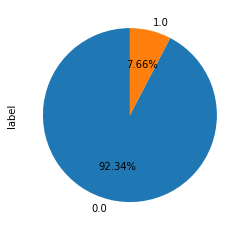

In [39]:
# 绘制是否点击的饼图
train_data['label'].value_counts().plot.pie(labeldistance = 1.1,autopct = '%1.2f%%',
                                               shadow = False,startangle = 90,pctdistance = 0.6)

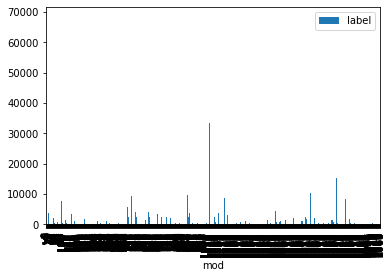

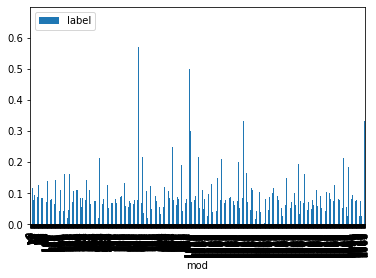

In [61]:
# 手机型号mod和是否点击的关系
train_data[['mod','label']].groupby(['mod']).count().plot.bar()
train_data[['mod','label']].groupby(['mod']).mean().plot.bar()

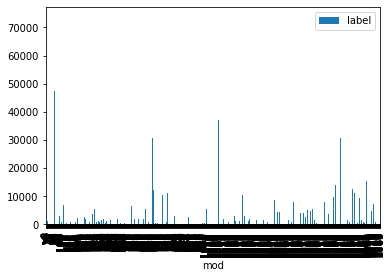

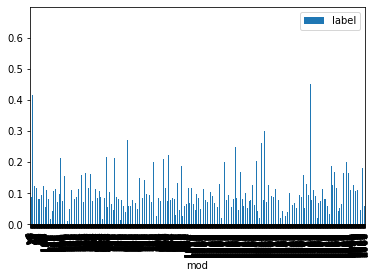

In [62]:
valid_data[['mod','label']].groupby(['mod']).count().plot.bar()
valid_data[['mod','label']].groupby(['mod']).mean().plot.bar()

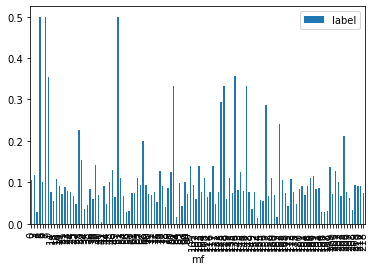

In [41]:
# 手机厂商mf和是否点击的关系
train_data[['mf','label']].groupby(['mf']).mean().plot.bar()

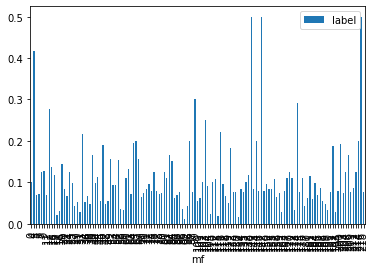

In [47]:
valid_data[['mf','label']].groupby(['mf']).mean().plot.bar()

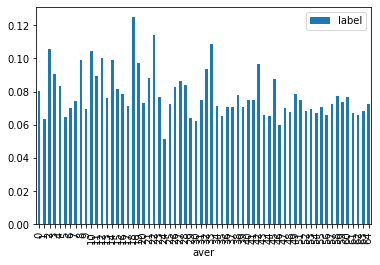

In [42]:
# 芒果tv版本aver和是否点击的关系
train_data[['aver','label']].groupby(['aver']).mean().plot.bar()

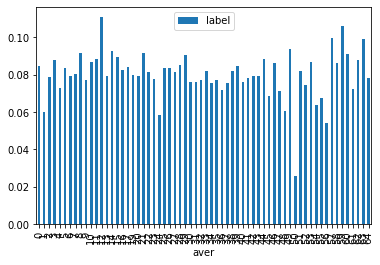

In [48]:
valid_data[['aver','label']].groupby(['aver']).mean().plot.bar()

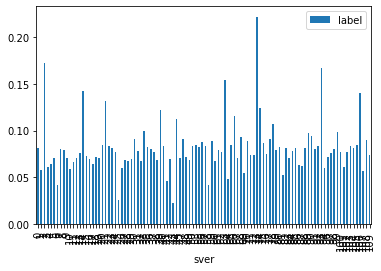

In [43]:
# 手机操作系统版本sver和是否点击的关系
train_data[['sver','label']].groupby(['sver']).mean().plot.bar()

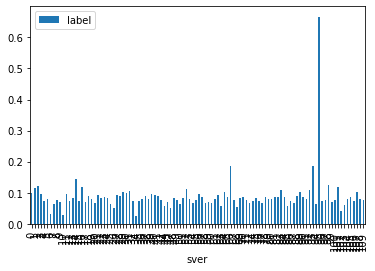

In [49]:
valid_data[['sver','label']].groupby(['sver']).mean().plot.bar()

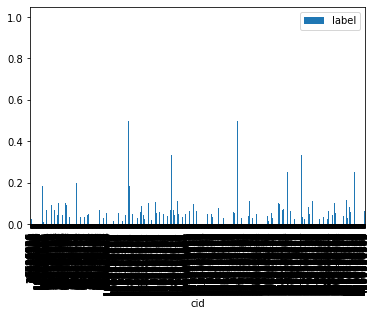

In [55]:
# 视频所属合集cid和是否点击的关系(相关性比较高)
train_data[['cid','label']].groupby(['cid']).mean().plot.bar()

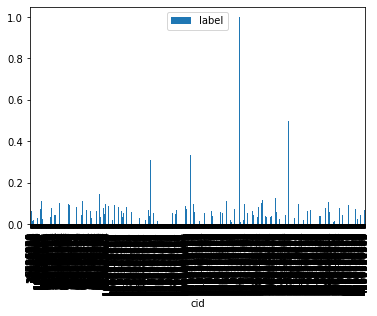

In [56]:
valid_data[['cid','label']].groupby(['cid']).mean().plot.bar()

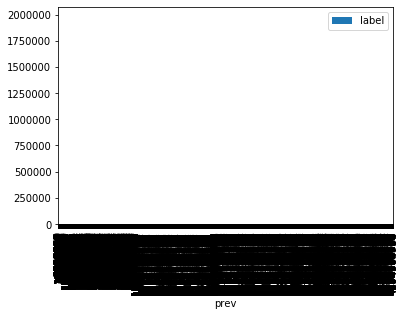

In [45]:
# 预览片id prev和是否点击关系(无关系)
train_data[['prev','label']].groupby(['prev']).count().plot.bar()

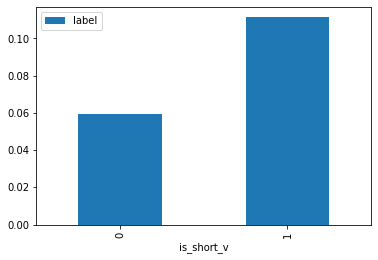

In [57]:
# 预览片id是否为0(短片还是长片)和是否点击关系(短片点击率低,长片点击率高)
train_data[['is_short_v','label']].groupby(['is_short_v']).mean().plot.bar()

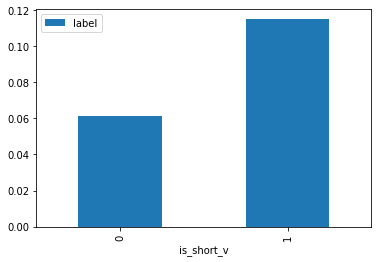

In [58]:
valid_data[['is_short_v','label']].groupby(['is_short_v']).mean().plot.bar()

In [51]:
# 短片和长片数量
train_data.loc[:,'is_short_v'].value_counts()

0    1976759
1     977825
Name: is_short_v, dtype: int64

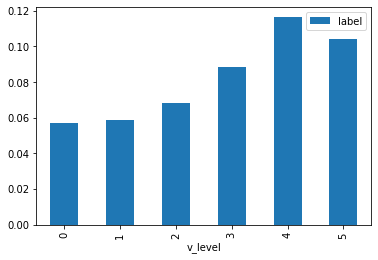

In [68]:
# 视频长度和label关系
train_data[['v_level','label']].groupby(['v_level']).mean().plot.bar()

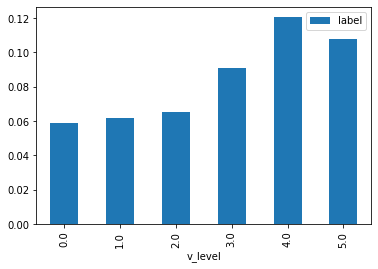

In [140]:
valid_data[['v_level','label']].groupby(['v_level']).mean().plot.bar()

In [142]:
train_data['v_level'].value_counts()

1.0    857740
0.0    673084
5.0    600812
2.0    356067
4.0    335921
3.0    130960
Name: v_level, dtype: int64

In [143]:
valid_data['v_level'].value_counts()

1.0    962217
0.0    786496
5.0    683860
2.0    395952
4.0    357899
3.0    138089
Name: v_level, dtype: int64

In [144]:
test_data['v_level'].value_counts()

1.0    1657783
0.0    1333348
5.0    1000120
2.0     679816
4.0     645932
3.0     248250
Name: v_level, dtype: int64

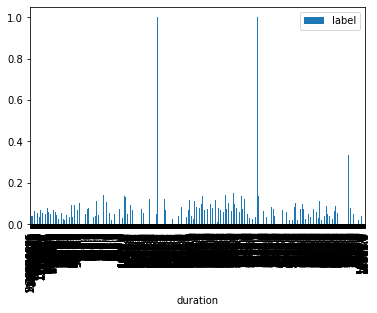

In [149]:
train_data[['duration','label']].groupby(['duration']).mean().plot.bar()

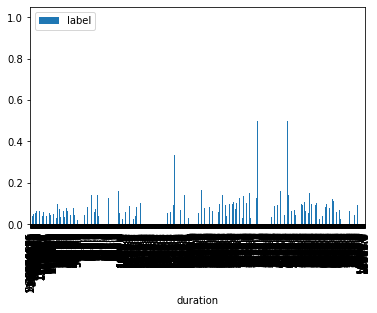

In [150]:
valid_data[['duration','label']].groupby(['duration']).mean().plot.bar()

In [78]:
train_data['duration'].describe()

count    2.954584e+06
mean              NaN
std               NaN
min      3.269531e+00
25%      6.537500e+01
50%      1.700000e+02
75%      2.896000e+03
max      2.361600e+04
Name: duration, dtype: float64

In [79]:
valid_data['duration'].describe()

count    3.324513e+06
mean              NaN
std               NaN
min      3.269531e+00
25%      6.431250e+01
50%      1.613750e+02
75%      2.858000e+03
max      2.361600e+04
Name: duration, dtype: float64

In [80]:
test_data['duration'].describe()

count    5.565249e+06
mean              NaN
std               NaN
min      3.269531e+00
25%      6.321875e+01
50%      1.537500e+02
75%      2.620000e+03
max      2.361600e+04
Name: duration, dtype: float64

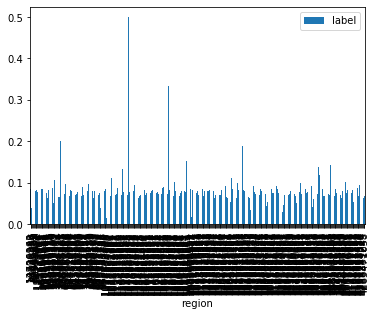

In [81]:
# 地域和label的关系
train_data[['region','label']].groupby(['region']).mean().plot.bar()

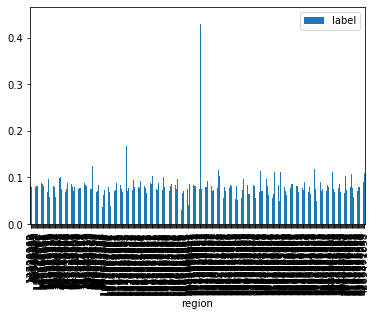

In [82]:
valid_data[['region','label']].groupby(['region']).mean().plot.bar()

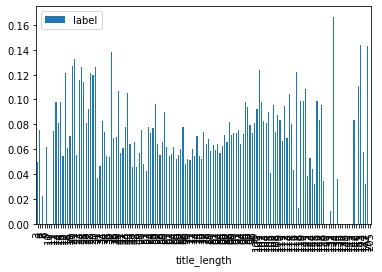

In [85]:
train_data[['title_length','label']].groupby(['title_length']).mean().plot.bar()

In [91]:
train_data['title_length'].describe()

count    2.954584e+06
mean     7.169437e+01
std      2.665995e+01
min      3.000000e+00
25%      5.500000e+01
50%      7.600000e+01
75%      9.200000e+01
max      2.050000e+02
Name: title_length, dtype: float64

In [82]:
valid_data['title_length'].describe()

count    3.324513e+06
mean     7.202290e+01
std      2.644028e+01
min      3.000000e+00
25%      5.500000e+01
50%      7.600000e+01
75%      9.200000e+01
max      1.940000e+02
Name: title_length, dtype: float64

In [83]:
test_data['title_length'].describe()

count    5.565249e+06
mean     7.169588e+01
std      2.651745e+01
min      3.000000e+00
25%      5.500000e+01
50%      7.600000e+01
75%      9.000000e+01
max      2.050000e+02
Name: title_length, dtype: float64

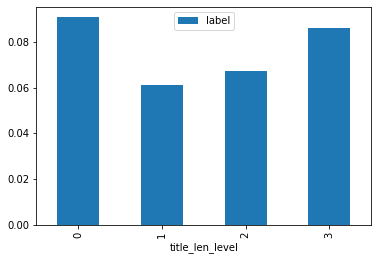

In [138]:
# 标题长度和level的关系
train_data[['title_len_level','label']].groupby(['title_len_level']).mean().plot.bar()

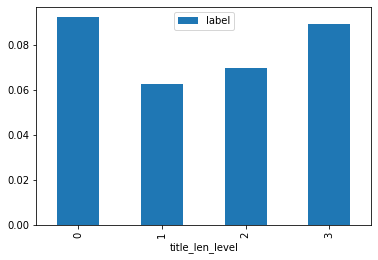

In [139]:
valid_data[['title_len_level','label']].groupby(['title_len_level']).mean().plot.bar()

In [81]:
train_data['title_len_level'].value_counts()

3    2947886
1       3521
2       2995
0        182
Name: title_len_level, dtype: int64

In [108]:
train_data[['item_timestamp', 'item_year', 'item_month', 'item_day', 'item_hour']]

,item_timestamp,item_year,item_month,item_day,item_hour
0,1321797554,2011,11,20,21
1,1324826507,2011,12,25,23
2,1325431836,2012,1,1,23
3,1348328772,2012,9,22,23
4,1367681684,2013,5,4,23
...,...,...,...,...,...
2954579,1426212003,2015,3,13,10
2954580,1426248448,2015,3,13,20
2954581,1426250733,2015,3,13,20
2954582,1426334674,2015,3,14,20


In [109]:
ttime = get_time(1321797554)
ttime

'2011-11-20 21:59:14'

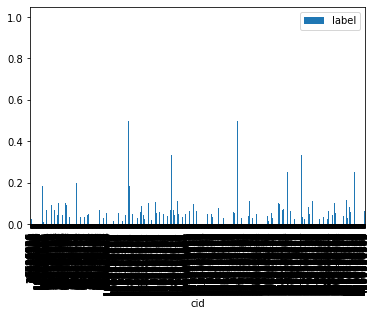

In [43]:
# 视频所属合集与label关系
train_data[['cid','label']].groupby(['cid']).mean().plot.bar()

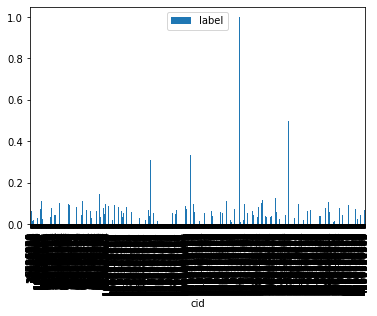

In [44]:
valid_data[['cid','label']].groupby(['cid']).mean().plot.bar()

In [45]:
# cid取值共2433个,用词向量方式
train_data['cid'].value_counts()

1281369743    100807
2759972708     85490
3303815793     80946
664136145      65973
2596226704     52244
               ...  
2713734189         1
2691046699         1
3628769468         1
2693805267         1
2722424675         1
Name: cid, Length: 2433, dtype: int64

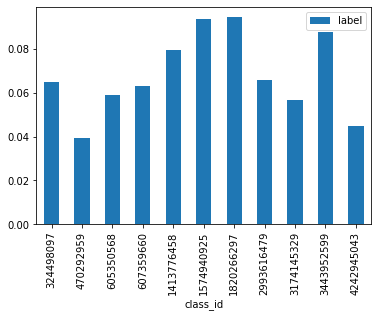

In [55]:
train_data[['class_id','label']].groupby(['class_id']).mean().plot.bar()

In [58]:
test_data['class_id'].value_counts()

1413776458    2187348
1820266297    1213868
605350568     1058024
607359660      574213
3443952599     175199
470292959      167618
3174145329     126650
1574940925      38679
4242945043      17082
2993616479       4742
324498097        1826
Name: class_id, dtype: int64

In [59]:
train_data['class_id'].value_counts()

1413776458    1206983
1820266297     685574
605350568      530589
607359660      222171
3443952599     121831
470292959       85206
3174145329      73190
1574940925      17667
4242945043       8373
2993616479       1624
324498097        1376
Name: class_id, dtype: int64

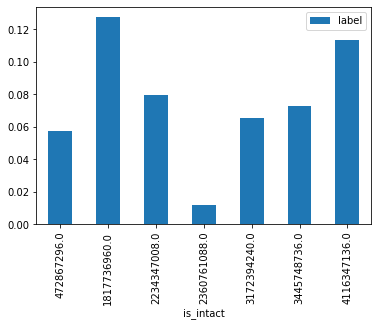

In [65]:
# 正短片类型is_intact和label的关系
train_data[['is_intact','label']].groupby(['is_intact']).mean().plot.bar()

In [73]:
train_data['is_intact'].value_counts()

2    2262885
5     335632
4     210689
0     137570
1       4631
6       2835
3        342
Name: is_intact, dtype: int64

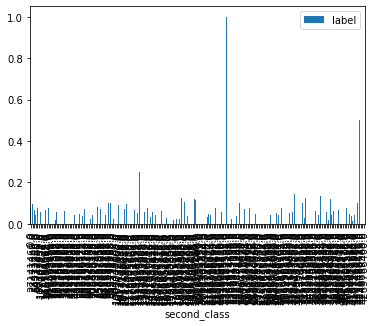

In [67]:
# 二级分类second_class和label的关系
train_data[['second_class','label']].groupby(['second_class']).mean().plot.bar()

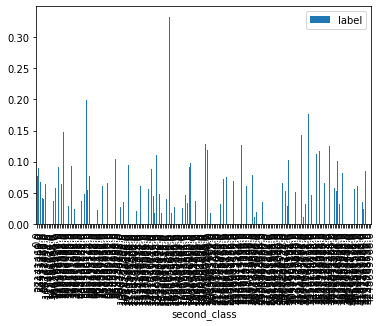

In [68]:
valid_data[['second_class','label']].groupby(['second_class']).mean().plot.bar()

In [69]:
train_data['second_class'].value_counts()

0.000000e+00    2602548
1.112680e+09      85512
3.313280e+09      49294
1.987569e+09      20573
7.413894e+08      20245
                 ...   
2.855592e+09          1
6.051324e+08          1
5.822938e+08          1
3.043663e+09          1
1.945308e+09          1
Name: second_class, Length: 207, dtype: int64

In [154]:
valid_data['second_class'].value_counts()

0.000000e+00    2944329
1.112680e+09      92895
3.313280e+09      51946
7.413894e+08      23874
1.987569e+09      22407
                 ...   
6.479204e+08          1
2.750635e+09          1
1.945308e+09          1
2.686624e+09          1
1.904585e+09          1
Name: second_class, Length: 205, dtype: int64

In [155]:
test_data['second_class'].value_counts()

0.000000e+00    4997183
1.112680e+09     124753
3.313280e+09      87360
5.453326e+07      42135
1.987569e+09      32197
                 ...   
1.216078e+09          1
1.254425e+09          1
3.436771e+09          1
2.168618e+09          1
3.151758e+09          1
Name: second_class, Length: 234, dtype: int64

In [157]:
train_data['count_second_class'].value_counts()

10544060.0    2602548
303160.0        85512
188600.0        49294
75177.0         20573
66851.0         20245
               ...   
20.0                4
32.0                3
64.0                2
13.0                2
19.0                1
Name: count_second_class, Length: 147, dtype: int64

In [158]:
valid_data['count_second_class'].value_counts()

10544060.0    2944329
303160.0        92895
188600.0        51946
66851.0         23874
75177.0         22407
               ...   
62.0                3
61.0                3
10.0                1
13.0                1
37.0                1
Name: count_second_class, Length: 150, dtype: int64

In [156]:
test_data['count_second_class'].value_counts()

10544060.0    4997183
303160.0       124753
188600.0        87360
83832.0         42135
75177.0         32197
               ...   
25.0                8
6.0                 8
8.0                 6
16.0                5
19.0                5
Name: count_second_class, Length: 151, dtype: int64

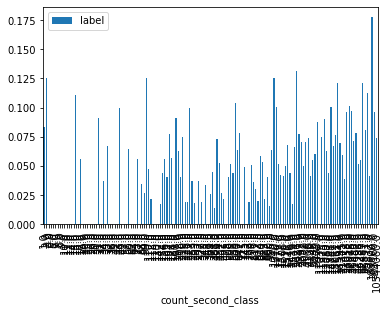

In [160]:
train_data[['count_second_class','label']].groupby(['count_second_class']).mean().plot.bar()

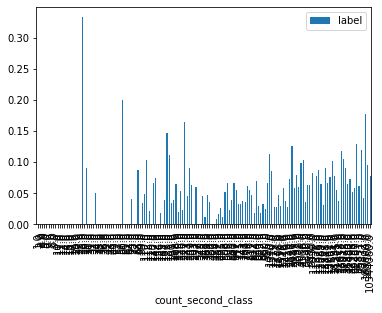

In [161]:
valid_data[['count_second_class','label']].groupby(['count_second_class']).mean().plot.bar()

In [72]:
data['vid'].value_counts()

4.153053e+09    55737
2.872597e+09    52414
2.713920e+09    52092
4.268650e+09    47114
2.748792e+09    46056
                ...  
1.685420e+09        1
3.188628e+09        1
9.675830e+08        1
9.675998e+08        1
9.803450e+08        1
Name: vid, Length: 55803, dtype: int64

In [153]:
test_data.describe()

,label,mod,mf,aver,sver,vid,prev,region,index,title_length,item_timestamp,cid,class_id,is_intact,second_class,duration,ctr,vv,context_timestamp,context_day,context_hour,context_minute,item_year,item_month,item_day,item_hour,item_minute,did_stars_0,did_stars_1,did_stars_2,did_stars_3,did_stars_4,did_stars_5,did_stars_6,did_stars_7,did_vid_emb_016,did_vid_emb_116,did_vid_emb_216,did_vid_emb_316,did_vid_emb_416,did_vid_emb_516,did_vid_emb_616,did_vid_emb_716,did_vid_emb_816,did_vid_emb_916,did_vid_emb_1016,did_vid_emb_1116,did_vid_emb_1216,did_vid_emb_1316,did_vid_emb_1416,did_vid_emb_1516,vid_emb_0_16,vid_emb_1_16,vid_emb_2_16,vid_emb_3_16,vid_emb_4_16,vid_emb_5_16,vid_emb_6_16,vid_emb_7_16,vid_emb_8_16,vid_emb_9_16,vid_emb_10_16,vid_emb_11_16,vid_emb_12_16,vid_emb_13_16,vid_emb_14_16,vid_emb_15_16,did_cid_emb_08,did_cid_emb_18,did_cid_emb_28,did_cid_emb_38,did_cid_emb_48,did_cid_emb_58,did_cid_emb_68,did_cid_emb_78,cid_emb_0_8,cid_emb_1_8,cid_emb_2_8,cid_emb_3_8,cid_emb_4_8,cid_emb_5_8,cid_emb_6_8,cid_emb_7_8,did_second_class_emb_08,did_second_class_emb_18,did_second_class_emb_28,did_second_class_emb_38,did_second_class_emb_48,did_second_class_emb_58,did_second_class_emb_68,did_second_class_emb_78,second_class_emb_0_8,second_class_emb_1_8,second_class_emb_2_8,second_class_emb_3_8,second_class_emb_4_8,second_class_emb_5_8,second_class_emb_6_8,second_class_emb_7_8,count_mod,count_mf,count_aver,count_sver,count_did,count_vid,count_prev,count_region,count_cid,count_class_id,count_is_intact,count_second_class,is_short_v,v_level,title_len_level
count,0.0,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5565249.000,5565249.0,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5565249.0,5565249.0,5565249.0,5565249.0,5565249.0,5565249.0,5565249.0,5565249.0,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5.565249e+06,5565249.000,5565249.0,5565249.000,5565249.0,5565249.0,5565249.00,5.565249e+06,5.565249e+06,5565249.000,5565249.0,5565249.00,5565249.0,5565249.0,5.565249e+06
mean,NaN,9.673703e+02,1.533424e+02,2.549618e+01,7.111198e+01,2.186014e+09,8.841531e+08,2.184040e+09,2775654.500,NaN,1.454859e+09,2.166988e+09,4.137516e+00,2.337928e+00,1.879083e+08,NaN,NaN,5.344673e+05,1.484424e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.735000e+04,2405181.000,5482545.0,1639036.750,NaN,NaN,4616029.50,1.012300e+05,1.053708e+05,3107874.750,7198788.0,10037810.00,NaN,NaN,1.479480e+00
std,NaN,6.382295e+02,3.923866e+01,8.415295e+00,3.489826e+01,1.211932e+09,1.303463e+09,1.210649e+09,1603781.375,0.0,8.652262e+07,1.252569e+09,1.808247e+00,1.089990e+00,6.580995e+08,NaN,0.000000e+00,3.825041e+06,5.799298e+07,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000

In [136]:
train_data['title_len_level'].value_counts()

0    767092
1    733473
2    732253
3    721766
Name: title_len_level, dtype: int64

In [137]:
test_data['title_len_level'].value_counts()

2    1458502
0    1408956
1    1388352
3    1309439
Name: title_len_level, dtype: int64